# First Model Experiments

In this notebook I have made the first model experiments to have a baseline to start from. The objectives of this notebook are: 
* Deriving a data preparation procedure
* Define the models and metrics to use
* Track experiments and set up a model registry with MLFlow
* Saving a first draft of the models

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, f1_score

import xgboost as xgb

import optuna

import mlflow
from mlflow.tracking import MlflowClient

import pickle

In [2]:
RANDOM_STATE = 2024

MLFLOW_TRACKING_URI = "sqlite:///bank_churn.db"

In [3]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bank_churn_prediction")

2024/07/20 16:37:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/20 16:37:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/mlruns/1', creation_time=1721493434662, experiment_id='1', last_update_time=1721493434662, lifecycle_stage='active', name='bank_churn_prediction', tags={}>

To launch mlflow, execute the following command in your terminal: 

mlflow server --backend-store-uri sqlite:///bank_churn.db --default-artifact-root ./artifacts

### Data Preparation

In [4]:
data = pd.read_csv('./data/customer_churn_records.csv')

In [5]:
data.drop(['RowNumber','CustomerId','Surname'], 
          axis = 1, inplace = True)

categorical_variables = ['Geography', 'Gender', 'Card Type']
target = 'Exited'
isf_variables = [target, 'Age','CreditScore','NumOfProducts'] 

data[categorical_variables] = data[categorical_variables].astype('category')

In [6]:
test_size = 0.2

val_data, train_data = train_test_split(data, test_size=test_size, random_state=RANDOM_STATE)


The following cell has only been used once to save data and it's not necessary to run it again. 


In [8]:
# train_data.to_csv('./data/customer_churn_training_data.csv')
# val_data.to_csv('./data/customer_churn_validation_data.csv')

### Model Experiments - Anomaly Detection

In [9]:
def objective_isf(trial):
    
    with mlflow.start_run(run_name = "anomaly_detection"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "isolation_forest")
    
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
            'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
            'max_features': trial.suggest_int('max_features', 1, 4),
            'bootstrap': True,
            'warm_start': True,
            'random_state': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        isf = IsolationForest(**params)
        isf.fit(train_data[isf_variables])
        
        anomalies = isf.predict(val_data[isf_variables])
        
        pct_returning, pct_inliers = compute_isf_metrics(val_data[isf_variables], anomalies)
        score = (1 - pct_returning)*(1 - pct_inliers)
        
        mlflow.log_metric("pct_returning", pct_returning)
        mlflow.log_metric("pct_inliers", pct_inliers)
        mlflow.log_metric("score", score)
        
        mlflow.sklearn.log_model(isf, artifact_path="mlflow_models")
    
    return score

def compute_isf_metrics(val_data, anomalies):
    
    val_data['Anomalies'] = anomalies
    
    pct_returning = len(val_data[(val_data['Anomalies']==1) & (val_data[target]==0)])/len(val_data[val_data['Anomalies']==1])
    pct_inliers = len(val_data[val_data['Anomalies']==1])/len(anomalies)
    
    return pct_returning, pct_inliers

In [10]:
study_isf = optuna.create_study(direction='minimize') 
study_isf.optimize(objective_isf, n_trials=50) 

[I 2024-07-20 16:38:07,419] A new study created in memory with name: no-name-1aa46ba1-75a6-4562-9fd1-4befc642c109
[W 2024-07-20 16:38:07,761] Trial 0 failed with parameters: {} because of the following error: UnboundLocalError("local variable 'params' referenced before assignment").
Traceback (most recent call last):
  File "/home/codespace/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_9365/3285256625.py", line 7, in objective_isf
    mlflow.log_params(params)
UnboundLocalError: local variable 'params' referenced before assignment
[W 2024-07-20 16:38:07,768] Trial 0 failed with value None.


UnboundLocalError: local variable 'params' referenced before assignment

In [8]:
isf=IsolationForest(**study_isf.best_params)

isf.fit(train_data[isf_variables])

IsolationForest(contamination=0.5, max_features=2, n_estimators=140)

In [9]:
# With these parameters found in a couple of trials I obtained the best score
# n_estimators=150, 
# max_samples='auto', 
# contamination=0.45,
# max_features=1.0,
# bootstrap = True, 
# warm_start = True,
# random_state=RANDOM_STATE

In [10]:
anomalies = isf.predict(val_data[isf_variables])

data_anom = val_data.copy()
data_anom['Anomalies'] = anomalies
data_anom

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Anomalies
8276,580,Spain,Male,32,9,142188.20,2,0,1,128028.60,0,0,3,DIAMOND,332,1
9288,635,Germany,Female,36,9,81231.85,2,1,0,196731.08,0,0,3,GOLD,839,1
530,519,Spain,Female,57,2,119035.35,2,1,1,29871.79,0,0,3,SILVER,689,-1
8127,651,Germany,Male,35,8,110067.71,1,1,0,127678.95,1,1,2,GOLD,689,-1
9903,606,France,Female,36,10,0.00,2,0,1,155641.46,0,0,2,SILVER,813,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,666,France,Male,46,5,123873.19,1,1,1,177844.06,0,0,2,PLATINUM,742,1
2688,558,Germany,Male,32,4,108235.91,1,1,1,143783.28,0,0,4,DIAMOND,801,1
2656,779,Spain,Female,34,5,0.00,2,0,1,111676.63,0,0,1,SILVER,945,1
3578,704,Germany,Female,39,1,124640.51,1,1,0,116511.12,1,1,5,DIAMOND,565,-1


<Axes: xlabel='Exited', ylabel='Count'>

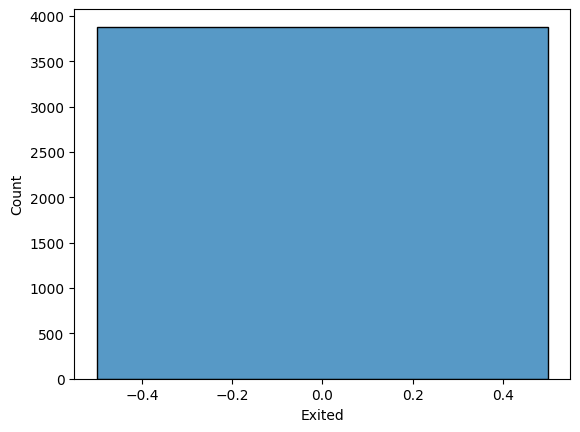

In [11]:
sns.histplot(data_anom[data_anom['Anomalies']==1][target], discrete=True)

<Axes: xlabel='Exited', ylabel='Count'>

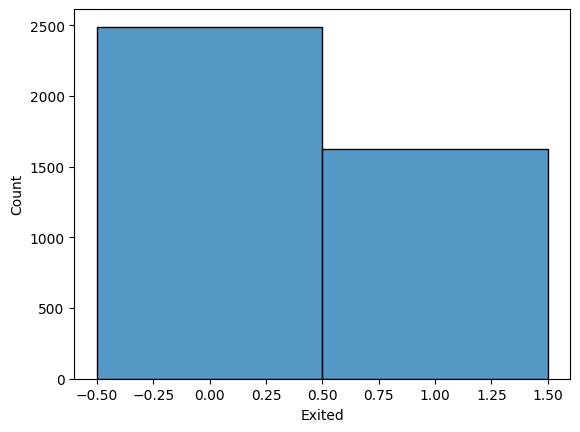

In [12]:
sns.histplot(data_anom[data_anom['Anomalies']==-1][target], discrete=True)

After applying anomaly detection, the dataset is not unbalanced anymore. Furthermore, we can already filter more than 40% of customers by setting a big chunk of returning customers on the side. 

<Axes: xlabel='Age', ylabel='Count'>

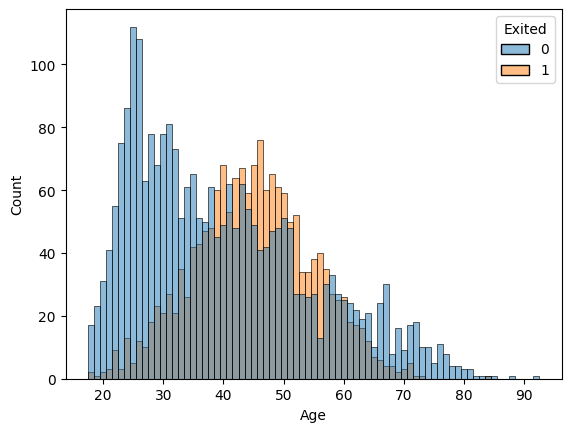

In [13]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='Age', hue=target, discrete=True)

<Axes: xlabel='Age', ylabel='Count'>

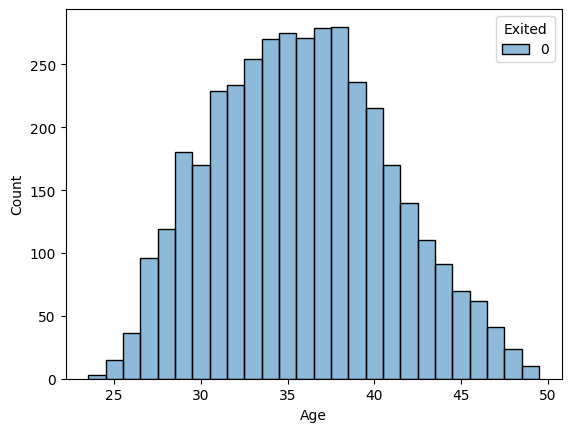

In [14]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='Age', hue=target, discrete=True)

<Axes: xlabel='NumOfProducts', ylabel='Count'>

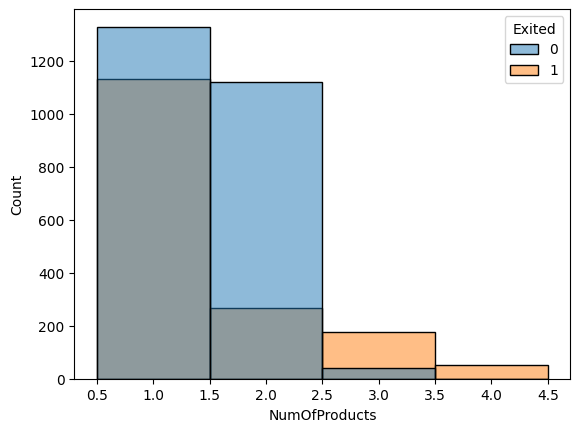

In [15]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='NumOfProducts', hue=target, discrete=True)

<Axes: xlabel='NumOfProducts', ylabel='Count'>

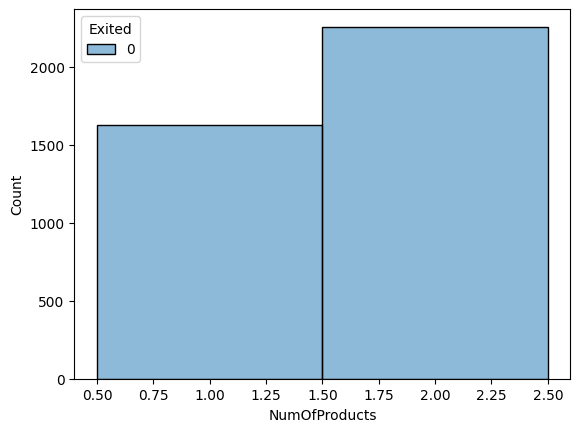

In [16]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='NumOfProducts', hue=target, discrete=True)

<Axes: xlabel='CreditScore', ylabel='Count'>

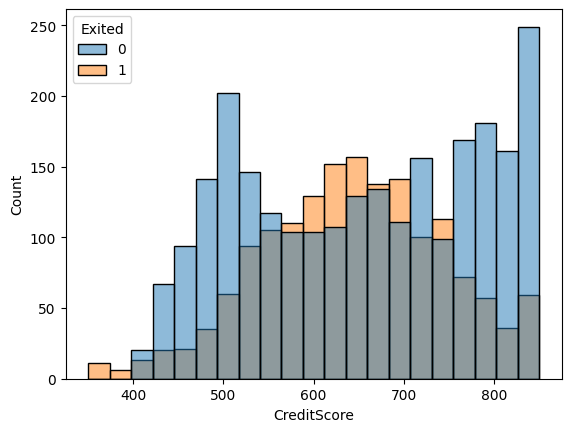

In [17]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='CreditScore', hue=target)

<Axes: xlabel='CreditScore', ylabel='Count'>

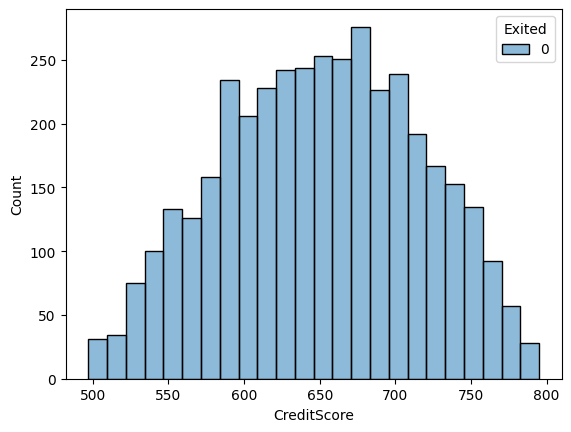

In [18]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='CreditScore', hue=target)

We can see how Isolation Forests also level out the most irregular distributions.

In [ ]:
with open('./models/isolation_forest.bin', 'wb') as f_out:
    pickle.dump(isf, f_out)

In [ ]:
mlflow.log_artifact("./models/isolation_forest.bin", artifact_path="isolation_forest")

In [ ]:
client = MlflowClient("http://127.0.0.1:5000")
client.list_registered_models()

In [ ]:
run_id = client.list_run_infos(experiment_id='1')[0].run_id
mlflow.register_model(
    model_uri=f"runs:/{run_id}/isolation_forest",
    name='isolation_forest'
)

In [ ]:
mlflow.end_run()

### Model Experiments - XGBoost

In [19]:
X_train = train_data.drop(target, axis=1)
y_train = train_data[target]

X_val = val_data.drop(target, axis=1)
y_val = val_data[target]

In [20]:
train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [21]:
def objective_xgb(trial):
    
    with mlflow.start_run(run_name = "xgboost_classifier"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "xgboost")
        mlflow.log_params(params)
        
        params = {
            'objective': 'binary:logistic',
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'seed': RANDOM_STATE
        }

        classifier = xgb.train(
                params = params,
                dtrain = train_matrix,
                num_boost_round = 1000,
                evals=[(val_matrix, 'validation')],
                early_stopping_rounds = 50
            )

        y_pred = np.rint(classifier.predict(val_matrix))

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        mlflow.xgboost.log_model(classifier, artifact_path="mlflow_models")
    
    return recall 

In [22]:
study_xgb = optuna.create_study(direction='maximize') 
study_xgb.optimize(objective_xgb, n_trials=50) 

[I 2024-07-20 01:40:42,353] A new study created in memory with name: no-name-4bda5c4f-9092-42a3-8961-dc1cf50a735c


[0]	validation-logloss:0.41397
[1]	validation-logloss:0.34846
[2]	validation-logloss:0.29796
[3]	validation-logloss:0.25777
[4]	validation-logloss:0.22467
[5]	validation-logloss:0.19708
[6]	validation-logloss:0.17360
[7]	validation-logloss:0.15329
[8]	validation-logloss:0.13608
[9]	validation-logloss:0.12069
[10]	validation-logloss:0.10730
[11]	validation-logloss:0.09595
[12]	validation-logloss:0.08585
[13]	validation-logloss:0.07700
[14]	validation-logloss:0.06909
[15]	validation-logloss:0.06234
[16]	validation-logloss:0.05616
[17]	validation-logloss:0.05114
[18]	validation-logloss:0.04650
[19]	validation-logloss:0.04219
[20]	validation-logloss:0.03860
[21]	validation-logloss:0.03542
[22]	validation-logloss:0.03240
[23]	validation-logloss:0.02993
[24]	validation-logloss:0.02753
[25]	validation-logloss:0.02562
[26]	validation-logloss:0.02386
[27]	validation-logloss:0.02270
[28]	validation-logloss:0.02147
[29]	validation-logloss:0.02019
[30]	validation-logloss:0.01930
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[62]	validation-logloss:0.00993
[63]	validation-logloss:0.00991
[64]	validation-logloss:0.00992
[65]	validation-logloss:0.00992
[66]	validation-logloss:0.00992
[67]	validation-logloss:0.00989
[68]	validation-logloss:0.00991
[69]	validation-logloss:0.00991
[70]	validation-logloss:0.00991
[71]	validation-logloss:0.00991
[72]	validation-logloss:0.00991
[73]	validation-logloss:0.00990
[74]	validation-logloss:0.00990
[75]	validation-logloss:0.00990
[76]	validation-logloss:0.00981
[77]	validation-logloss:0.00983
[78]	validation-logloss:0.00983
[79]	validation-logloss:0.00983
[80]	validation-logloss:0.00985
[81]	validation-logloss:0.00985
[82]	validation-logloss:0.00985
[83]	validation-logloss:0.00983
[84]	validation-logloss:0.00980
[85]	validation-logloss:0.00980
[86]	validation-logloss:0.00982
[87]	validation-logloss:0.00975
[88]	validation-logloss:0.00973
[89]	validation-logloss:0.00974
[90]	validation-logloss:0.00975
[91]	validation-logloss:0.00975
[92]	validation-logloss:0.00975
[93]	val

[I 2024-07-20 01:40:42,851] Trial 0 finished with value: 0.998158379373849 and parameters: {'n_estimators': 130, 'learning_rate': 0.11432845798980329, 'subsample': 0.35000000000000003, 'max_depth': 45}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.08507
[1]	validation-logloss:0.03607
[2]	validation-logloss:0.01881
[3]	validation-logloss:0.01272
[4]	validation-logloss:0.01042
[5]	validation-logloss:0.00995
[6]	validation-logloss:0.00984
[7]	validation-logloss:0.00957
[8]	validation-logloss:0.00982
[9]	validation-logloss:0.00980
[10]	validation-logloss:0.01006
[11]	validation-logloss:0.01065
[12]	validation-logloss:0.01066
[13]	validation-logloss:0.01085
[14]	validation-logloss:0.01053
[15]	validation-logloss:0.01032
[16]	validation-logloss:0.01045
[17]	validation-logloss:0.01076
[18]	validation-logloss:0.01048
[19]	validation-logloss:0.01001
[20]	validation-logloss:0.00979
[21]	validation-logloss:0.00992
[22]	validation-logloss:0.00986
[23]	validation-logloss:0.00969
[24]	validation-logloss:0.00976
[25]	validation-logloss:0.01010
[26]	validation-logloss:0.00976
[27]	validation-logloss:0.00967
[28]	validation-logloss:0.00966
[29]	validation-logloss:0.00966
[30]	validation-logloss:0.00966
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[0]	validation-logloss:0.49579
[1]	validation-logloss:0.48399
[2]	validation-logloss:0.47266
[3]	validation-logloss:0.46187
[4]	validation-logloss:0.45155
[5]	validation-logloss:0.44162
[6]	validation-logloss:0.43208
[7]	validation-logloss:0.42285
[8]	validation-logloss:0.41397
[9]	validation-logloss:0.40532
[10]	validation-logloss:0.39699
[11]	validation-logloss:0.38897
[12]	validation-logloss:0.38116
[13]	validation-logloss:0.37361
[14]	validation-logloss:0.36625
[15]	validation-logloss:0.35914
[16]	validation-logloss:0.35220
[17]	validation-logloss:0.34552
[18]	validation-logloss:0.33899
[19]	validation-logloss:0.33261
[20]	validation-logloss:0.32647
[21]	validation-logloss:0.32047
[22]	validation-logloss:0.31458
[23]	validation-logloss:0.30888
[24]	validation-logloss:0.30331
[25]	validation-logloss:0.29788
[26]	validation-logloss:0.29259
[27]	validation-logloss:0.28748
[28]	validation-logloss:0.28247
[29]	validation-logloss:0.27754
[30]	validation-logloss:0.27277
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[89]	validation-logloss:0.10927
[90]	validation-logloss:0.10774
[91]	validation-logloss:0.10621
[92]	validation-logloss:0.10474
[93]	validation-logloss:0.10330
[94]	validation-logloss:0.10190
[95]	validation-logloss:0.10051
[96]	validation-logloss:0.09911
[97]	validation-logloss:0.09776
[98]	validation-logloss:0.09643
[99]	validation-logloss:0.09510
[100]	validation-logloss:0.09379
[101]	validation-logloss:0.09250
[102]	validation-logloss:0.09127
[103]	validation-logloss:0.09000
[104]	validation-logloss:0.08877
[105]	validation-logloss:0.08756
[106]	validation-logloss:0.08635
[107]	validation-logloss:0.08519
[108]	validation-logloss:0.08402
[109]	validation-logloss:0.08293
[110]	validation-logloss:0.08183
[111]	validation-logloss:0.08077
[112]	validation-logloss:0.07972
[113]	validation-logloss:0.07865
[114]	validation-logloss:0.07759
[115]	validation-logloss:0.07655
[116]	validation-logloss:0.07555
[117]	validation-logloss:0.07457
[118]	validation-logloss:0.07358
[119]	validation-logl

[I 2024-07-20 01:40:44,557] Trial 2 finished with value: 0.998158379373849 and parameters: {'n_estimators': 230, 'learning_rate': 0.014121126971159617, 'subsample': 0.45, 'max_depth': 10}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.48672
[1]	validation-logloss:0.46698
[2]	validation-logloss:0.44869
[3]	validation-logloss:0.43169
[4]	validation-logloss:0.41577
[5]	validation-logloss:0.40081
[6]	validation-logloss:0.38673
[7]	validation-logloss:0.37342
[8]	validation-logloss:0.36081
[9]	validation-logloss:0.34876
[10]	validation-logloss:0.33743
[11]	validation-logloss:0.32658
[12]	validation-logloss:0.31617
[13]	validation-logloss:0.30625
[14]	validation-logloss:0.29671
[15]	validation-logloss:0.28764
[16]	validation-logloss:0.27893
[17]	validation-logloss:0.27060
[18]	validation-logloss:0.26256
[19]	validation-logloss:0.25483
[20]	validation-logloss:0.24744
[21]	validation-logloss:0.24029
[22]	validation-logloss:0.23336
[23]	validation-logloss:0.22673
[24]	validation-logloss:0.22035
[25]	validation-logloss:0.21418
[26]	validation-logloss:0.20822
[27]	validation-logloss:0.20253
[28]	validation-logloss:0.19704
[29]	validation-logloss:0.19165
[30]	validation-logloss:0.18649
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[63]	validation-logloss:0.08105
[64]	validation-logloss:0.07918
[65]	validation-logloss:0.07738
[66]	validation-logloss:0.07558
[67]	validation-logloss:0.07390
[68]	validation-logloss:0.07224
[69]	validation-logloss:0.07062
[70]	validation-logloss:0.06902
[71]	validation-logloss:0.06752
[72]	validation-logloss:0.06602
[73]	validation-logloss:0.06457
[74]	validation-logloss:0.06313
[75]	validation-logloss:0.06175
[76]	validation-logloss:0.06044
[77]	validation-logloss:0.05912
[78]	validation-logloss:0.05785
[79]	validation-logloss:0.05659
[80]	validation-logloss:0.05539
[81]	validation-logloss:0.05419
[82]	validation-logloss:0.05300
[83]	validation-logloss:0.05189
[84]	validation-logloss:0.05080
[85]	validation-logloss:0.04976
[86]	validation-logloss:0.04872
[87]	validation-logloss:0.04776
[88]	validation-logloss:0.04677
[89]	validation-logloss:0.04586
[90]	validation-logloss:0.04493
[91]	validation-logloss:0.04400
[92]	validation-logloss:0.04313
[93]	validation-logloss:0.04230
[94]	val

[I 2024-07-20 01:40:45,502] Trial 3 finished with value: 0.998158379373849 and parameters: {'n_estimators': 50, 'learning_rate': 0.024464201028638256, 'subsample': 0.55, 'max_depth': 81}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50732
[1]	validation-logloss:0.50646
[2]	validation-logloss:0.50561
[3]	validation-logloss:0.50479
[4]	validation-logloss:0.50395
[5]	validation-logloss:0.50312
[6]	validation-logloss:0.50231
[7]	validation-logloss:0.50150
[8]	validation-logloss:0.50067
[9]	validation-logloss:0.49984
[10]	validation-logloss:0.49902
[11]	validation-logloss:0.49819
[12]	validation-logloss:0.49736
[13]	validation-logloss:0.49655
[14]	validation-logloss:0.49575
[15]	validation-logloss:0.49494
[16]	validation-logloss:0.49412
[17]	validation-logloss:0.49333
[18]	validation-logloss:0.49252
[19]	validation-logloss:0.49169
[20]	validation-logloss:0.49089
[21]	validation-logloss:0.49010
[22]	validation-logloss:0.48931
[23]	validation-logloss:0.48853
[24]	validation-logloss:0.48773
[25]	validation-logloss:0.48693
[26]	validation-logloss:0.48614
[27]	validation-logloss:0.48534
[28]	validation-logloss:0.48456
[29]	validation-logloss:0.48382
[30]	validation-logloss:0.48305
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[102]	validation-logloss:0.43229
[103]	validation-logloss:0.43164
[104]	validation-logloss:0.43099
[105]	validation-logloss:0.43035
[106]	validation-logloss:0.42970
[107]	validation-logloss:0.42908
[108]	validation-logloss:0.42845
[109]	validation-logloss:0.42782
[110]	validation-logloss:0.42719
[111]	validation-logloss:0.42655
[112]	validation-logloss:0.42593
[113]	validation-logloss:0.42533
[114]	validation-logloss:0.42470
[115]	validation-logloss:0.42408
[116]	validation-logloss:0.42348
[117]	validation-logloss:0.42286
[118]	validation-logloss:0.42223
[119]	validation-logloss:0.42161
[120]	validation-logloss:0.42098
[121]	validation-logloss:0.42036
[122]	validation-logloss:0.41975
[123]	validation-logloss:0.41913
[124]	validation-logloss:0.41851
[125]	validation-logloss:0.41790
[126]	validation-logloss:0.41730
[127]	validation-logloss:0.41669
[128]	validation-logloss:0.41609
[129]	validation-logloss:0.41548
[130]	validation-logloss:0.41487
[131]	validation-logloss:0.41426
[132]	vali

[I 2024-07-20 01:40:47,600] Trial 4 finished with value: 0.998158379373849 and parameters: {'n_estimators': 610, 'learning_rate': 0.0010400366809990567, 'subsample': 0.1, 'max_depth': 78}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.42829
[1]	validation-logloss:0.36965
[2]	validation-logloss:0.32304
[3]	validation-logloss:0.28496
[4]	validation-logloss:0.25299
[5]	validation-logloss:0.22574
[6]	validation-logloss:0.20215
[7]	validation-logloss:0.18148
[8]	validation-logloss:0.16350
[9]	validation-logloss:0.14735
[10]	validation-logloss:0.13322
[11]	validation-logloss:0.12079
[12]	validation-logloss:0.10959
[13]	validation-logloss:0.09958
[14]	validation-logloss:0.09053
[15]	validation-logloss:0.08252
[16]	validation-logloss:0.07523
[17]	validation-logloss:0.06891
[18]	validation-logloss:0.06318
[19]	validation-logloss:0.05785
[20]	validation-logloss:0.05329
[21]	validation-logloss:0.04909
[22]	validation-logloss:0.04517
[23]	validation-logloss:0.04181
[24]	validation-logloss:0.03870
[25]	validation-logloss:0.03593
[26]	validation-logloss:0.03339
[27]	validation-logloss:0.03141
[28]	validation-logloss:0.02946
[29]	validation-logloss:0.02756
[30]	validation-logloss:0.02599
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[99]	validation-logloss:0.00950
[100]	validation-logloss:0.00948
[101]	validation-logloss:0.00947
[102]	validation-logloss:0.00945
[103]	validation-logloss:0.00944
[104]	validation-logloss:0.00945
[105]	validation-logloss:0.00946
[106]	validation-logloss:0.00946
[107]	validation-logloss:0.00940
[108]	validation-logloss:0.00940
[109]	validation-logloss:0.00939
[110]	validation-logloss:0.00940
[111]	validation-logloss:0.00944
[112]	validation-logloss:0.00948
[113]	validation-logloss:0.00947
[114]	validation-logloss:0.00947
[115]	validation-logloss:0.00943
[116]	validation-logloss:0.00937
[117]	validation-logloss:0.00939
[118]	validation-logloss:0.00938
[119]	validation-logloss:0.00934
[120]	validation-logloss:0.00938
[121]	validation-logloss:0.00935
[122]	validation-logloss:0.00935
[123]	validation-logloss:0.00935
[124]	validation-logloss:0.00935
[125]	validation-logloss:0.00932
[126]	validation-logloss:0.00932
[127]	validation-logloss:0.00932
[128]	validation-logloss:0.00932
[129]	valid

[I 2024-07-20 01:40:48,104] Trial 5 finished with value: 0.998158379373849 and parameters: {'n_estimators': 880, 'learning_rate': 0.09514918735143857, 'subsample': 0.45, 'max_depth': 78}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.37587
[1]	validation-logloss:0.29748
[2]	validation-logloss:0.24144
[3]	validation-logloss:0.19890
[4]	validation-logloss:0.16532
[5]	validation-logloss:0.13868
[6]	validation-logloss:0.11690
[7]	validation-logloss:0.09907
[8]	validation-logloss:0.08437
[9]	validation-logloss:0.07206
[10]	validation-logloss:0.06208
[11]	validation-logloss:0.05360
[12]	validation-logloss:0.04642
[13]	validation-logloss:0.04052
[14]	validation-logloss:0.03533
[15]	validation-logloss:0.03141
[16]	validation-logloss:0.02801
[17]	validation-logloss:0.02527
[18]	validation-logloss:0.02266
[19]	validation-logloss:0.02047
[20]	validation-logloss:0.01877
[21]	validation-logloss:0.01722
[22]	validation-logloss:0.01582
[23]	validation-logloss:0.01476
[24]	validation-logloss:0.01396
[25]	validation-logloss:0.01325
[26]	validation-logloss:0.01282
[27]	validation-logloss:0.01251
[28]	validation-logloss:0.01220
[29]	validation-logloss:0.01177
[30]	validation-logloss:0.01163
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[72]	validation-logloss:0.00953
[73]	validation-logloss:0.00960
[74]	validation-logloss:0.00955
[75]	validation-logloss:0.00954
[76]	validation-logloss:0.00961
[77]	validation-logloss:0.00969
[78]	validation-logloss:0.00974
[79]	validation-logloss:0.00972
[80]	validation-logloss:0.00967
[81]	validation-logloss:0.00967
[82]	validation-logloss:0.00966
[83]	validation-logloss:0.00968
[84]	validation-logloss:0.00972
[85]	validation-logloss:0.00969
[86]	validation-logloss:0.00970
[87]	validation-logloss:0.00968
[88]	validation-logloss:0.00970
[89]	validation-logloss:0.00971
[90]	validation-logloss:0.00978
[91]	validation-logloss:0.00968
[92]	validation-logloss:0.00972
[93]	validation-logloss:0.00979
[94]	validation-logloss:0.00986
[95]	validation-logloss:0.00984
[96]	validation-logloss:0.00987
[97]	validation-logloss:0.00988
[98]	validation-logloss:0.00987
[99]	validation-logloss:0.00986
[100]	validation-logloss:0.00985
[101]	validation-logloss:0.00980
[102]	validation-logloss:0.00979
[103]

[I 2024-07-20 01:40:48,384] Trial 6 finished with value: 0.998158379373849 and parameters: {'n_estimators': 50, 'learning_rate': 0.16236436208832827, 'subsample': 0.7000000000000001, 'max_depth': 89}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.18416
[1]	validation-logloss:0.10374
[2]	validation-logloss:0.06253
[3]	validation-logloss:0.04152
[4]	validation-logloss:0.02819
[5]	validation-logloss:0.02167
[6]	validation-logloss:0.01700
[7]	validation-logloss:0.01485
[8]	validation-logloss:0.01426
[9]	validation-logloss:0.01245
[10]	validation-logloss:0.01241
[11]	validation-logloss:0.01265
[12]	validation-logloss:0.01254
[13]	validation-logloss:0.01218
[14]	validation-logloss:0.01217
[15]	validation-logloss:0.01217
[16]	validation-logloss:0.01217
[17]	validation-logloss:0.01218
[18]	validation-logloss:0.01220
[19]	validation-logloss:0.01212
[20]	validation-logloss:0.01213
[21]	validation-logloss:0.01208
[22]	validation-logloss:0.01206
[23]	validation-logloss:0.01205
[24]	validation-logloss:0.01208
[25]	validation-logloss:0.01211
[26]	validation-logloss:0.01212
[27]	validation-logloss:0.01211
[28]	validation-logloss:0.01210
[29]	validation-logloss:0.01220
[30]	validation-logloss:0.01213
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[0]	validation-logloss:0.50314
[1]	validation-logloss:0.49823
[2]	validation-logloss:0.49339
[3]	validation-logloss:0.48866
[4]	validation-logloss:0.48402
[5]	validation-logloss:0.47947
[6]	validation-logloss:0.47499
[7]	validation-logloss:0.47058
[8]	validation-logloss:0.46624
[9]	validation-logloss:0.46197
[10]	validation-logloss:0.45778


C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[11]	validation-logloss:0.45365
[12]	validation-logloss:0.44959
[13]	validation-logloss:0.44560
[14]	validation-logloss:0.44163
[15]	validation-logloss:0.43776
[16]	validation-logloss:0.43394
[17]	validation-logloss:0.43018
[18]	validation-logloss:0.42647
[19]	validation-logloss:0.42281
[20]	validation-logloss:0.41920
[21]	validation-logloss:0.41565
[22]	validation-logloss:0.41213
[23]	validation-logloss:0.40868
[24]	validation-logloss:0.40526
[25]	validation-logloss:0.40188
[26]	validation-logloss:0.39857
[27]	validation-logloss:0.39530
[28]	validation-logloss:0.39207
[29]	validation-logloss:0.38888
[30]	validation-logloss:0.38573
[31]	validation-logloss:0.38262
[32]	validation-logloss:0.37954
[33]	validation-logloss:0.37650
[34]	validation-logloss:0.37351
[35]	validation-logloss:0.37055
[36]	validation-logloss:0.36763
[37]	validation-logloss:0.36474
[38]	validation-logloss:0.36189
[39]	validation-logloss:0.35906
[40]	validation-logloss:0.35626
[41]	validation-logloss:0.35351
[42]	val

[I 2024-07-20 01:40:50,770] Trial 8 finished with value: 0.998158379373849 and parameters: {'n_estimators': 470, 'learning_rate': 0.005644948941504184, 'subsample': 0.8500000000000001, 'max_depth': 51}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.47896
[1]	validation-logloss:0.45204
[2]	validation-logloss:0.42771
[3]	validation-logloss:0.40623
[4]	validation-logloss:0.38599
[5]	validation-logloss:0.36722
[6]	validation-logloss:0.35018
[7]	validation-logloss:0.33431
[8]	validation-logloss:0.31927
[9]	validation-logloss:0.30505
[10]	validation-logloss:0.29167
[11]	validation-logloss:0.27893
[12]	validation-logloss:0.26701
[13]	validation-logloss:0.25601
[14]	validation-logloss:0.24549
[15]	validation-logloss:0.23553
[16]	validation-logloss:0.22589
[17]	validation-logloss:0.21716
[18]	validation-logloss:0.20855
[19]	validation-logloss:0.20028
[20]	validation-logloss:0.19252
[21]	validation-logloss:0.18520
[22]	validation-logloss:0.17817
[23]	validation-logloss:0.17152
[24]	validation-logloss:0.16509
[25]	validation-logloss:0.15898
[26]	validation-logloss:0.15312
[27]	validation-logloss:0.14749
[28]	validation-logloss:0.14219
[29]	validation-logloss:0.13740
[30]	validation-logloss:0.13258
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[100]	validation-logloss:0.02301
[101]	validation-logloss:0.02262
[102]	validation-logloss:0.02251
[103]	validation-logloss:0.02212
[104]	validation-logloss:0.02174
[105]	validation-logloss:0.02139
[106]	validation-logloss:0.02105
[107]	validation-logloss:0.02083
[108]	validation-logloss:0.02050
[109]	validation-logloss:0.02027
[110]	validation-logloss:0.02007
[111]	validation-logloss:0.01975
[112]	validation-logloss:0.01963
[113]	validation-logloss:0.01955
[114]	validation-logloss:0.01927
[115]	validation-logloss:0.01900
[116]	validation-logloss:0.01890
[117]	validation-logloss:0.01864
[118]	validation-logloss:0.01838
[119]	validation-logloss:0.01812
[120]	validation-logloss:0.01786
[121]	validation-logloss:0.01763
[122]	validation-logloss:0.01741
[123]	validation-logloss:0.01739
[124]	validation-logloss:0.01717
[125]	validation-logloss:0.01697
[126]	validation-logloss:0.01692
[127]	validation-logloss:0.01671
[128]	validation-logloss:0.01671
[129]	validation-logloss:0.01670
[130]	vali

[I 2024-07-20 01:40:52,001] Trial 9 finished with value: 0.998158379373849 and parameters: {'n_estimators': 860, 'learning_rate': 0.03672289910024647, 'subsample': 0.1, 'max_depth': 2}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.33951
[1]	validation-logloss:0.25270
[2]	validation-logloss:0.19396
[3]	validation-logloss:0.15216
[4]	validation-logloss:0.12050
[5]	validation-logloss:0.09678
[6]	validation-logloss:0.07865
[7]	validation-logloss:0.06444
[8]	validation-logloss:0.05363
[9]	validation-logloss:0.04440
[10]	validation-logloss:0.03713
[11]	validation-logloss:0.03176
[12]	validation-logloss:0.02716
[13]	validation-logloss:0.02389
[14]	validation-logloss:0.02095
[15]	validation-logloss:0.01892
[16]	validation-logloss:0.01699
[17]	validation-logloss:0.01601
[18]	validation-logloss:0.01494
[19]	validation-logloss:0.01381
[20]	validation-logloss:0.01319
[21]	validation-logloss:0.01267
[22]	validation-logloss:0.01204
[23]	validation-logloss:0.01181
[24]	validation-logloss:0.01131
[25]	validation-logloss:0.01124
[26]	validation-logloss:0.01103
[27]	validation-logloss:0.01086
[28]	validation-logloss:0.01076
[29]	validation-logloss:0.01074
[30]	validation-logloss:0.01081
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[53]	validation-logloss:0.01027
[54]	validation-logloss:0.01028
[55]	validation-logloss:0.01028
[56]	validation-logloss:0.01032
[57]	validation-logloss:0.01031
[58]	validation-logloss:0.01027
[59]	validation-logloss:0.01028
[60]	validation-logloss:0.01028
[61]	validation-logloss:0.01026
[62]	validation-logloss:0.01027
[63]	validation-logloss:0.01030
[64]	validation-logloss:0.01029
[65]	validation-logloss:0.01029
[66]	validation-logloss:0.01029
[67]	validation-logloss:0.01031
[68]	validation-logloss:0.01030
[69]	validation-logloss:0.01029
[70]	validation-logloss:0.01028
[71]	validation-logloss:0.01030
[72]	validation-logloss:0.01031
[73]	validation-logloss:0.01034
[74]	validation-logloss:0.01038
[75]	validation-logloss:0.01040
[76]	validation-logloss:0.01040
[77]	validation-logloss:0.01041
[78]	validation-logloss:0.01036
[79]	validation-logloss:0.01034
[80]	validation-logloss:0.01030
[81]	validation-logloss:0.01030
[82]	validation-logloss:0.01030
[83]	validation-logloss:0.01030
[84]	val

[I 2024-07-20 01:40:52,366] Trial 10 finished with value: 0.998158379373849 and parameters: {'n_estimators': 290, 'learning_rate': 0.2206645329650705, 'subsample': 0.25, 'max_depth': 33}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49745
[1]	validation-logloss:0.48714
[2]	validation-logloss:0.47718
[3]	validation-logloss:0.46767
[4]	validation-logloss:0.45853
[5]	validation-logloss:0.44971
[6]	validation-logloss:0.44120
[7]	validation-logloss:0.43290
[8]	validation-logloss:0.42489
[9]	validation-logloss:0.41705
[10]	validation-logloss:0.40944
[11]	validation-logloss:0.40213
[12]	validation-logloss:0.39498
[13]	validation-logloss:0.38805
[14]	validation-logloss:0.38128
[15]	validation-logloss:0.37471
[16]	validation-logloss:0.36828
[17]	validation-logloss:0.36208
[18]	validation-logloss:0.35602
[19]	validation-logloss:0.35006
[20]	validation-logloss:0.34430
[21]	validation-logloss:0.33868
[22]	validation-logloss:0.33314
[23]	validation-logloss:0.32779
[24]	validation-logloss:0.32249
[25]	validation-logloss:0.31735
[26]	validation-logloss:0.31233
[27]	validation-logloss:0.30750
[28]	validation-logloss:0.30275
[29]	validation-logloss:0.29805
[30]	validation-logloss:0.29349
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[83]	validation-logloss:0.14005
[84]	validation-logloss:0.13826
[85]	validation-logloss:0.13648
[86]	validation-logloss:0.13475
[87]	validation-logloss:0.13305
[88]	validation-logloss:0.13139
[89]	validation-logloss:0.12975
[90]	validation-logloss:0.12813
[91]	validation-logloss:0.12650
[92]	validation-logloss:0.12490
[93]	validation-logloss:0.12336
[94]	validation-logloss:0.12188
[95]	validation-logloss:0.12041
[96]	validation-logloss:0.11892
[97]	validation-logloss:0.11744
[98]	validation-logloss:0.11602
[99]	validation-logloss:0.11458
[100]	validation-logloss:0.11317
[101]	validation-logloss:0.11176
[102]	validation-logloss:0.11043
[103]	validation-logloss:0.10906
[104]	validation-logloss:0.10770
[105]	validation-logloss:0.10637
[106]	validation-logloss:0.10506
[107]	validation-logloss:0.10380
[108]	validation-logloss:0.10252
[109]	validation-logloss:0.10131
[110]	validation-logloss:0.10011
[111]	validation-logloss:0.09894
[112]	validation-logloss:0.09779
[113]	validation-logloss:0.

[I 2024-07-20 01:40:55,325] Trial 11 finished with value: 0.998158379373849 and parameters: {'n_estimators': 250, 'learning_rate': 0.012321346464384247, 'subsample': 0.35000000000000003, 'max_depth': 8}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50434
[1]	validation-logloss:0.50058
[2]	validation-logloss:0.49688
[3]	validation-logloss:0.49323
[4]	validation-logloss:0.48964
[5]	validation-logloss:0.48609
[6]	validation-logloss:0.48260
[7]	validation-logloss:0.47914
[8]	validation-logloss:0.47574
[9]	validation-logloss:0.47235
[10]	validation-logloss:0.46904
[11]	validation-logloss:0.46576
[12]	validation-logloss:0.46251
[13]	validation-logloss:0.45931
[14]	validation-logloss:0.45613
[15]	validation-logloss:0.45300
[16]	validation-logloss:0.44991
[17]	validation-logloss:0.44687
[18]	validation-logloss:0.44385
[19]	validation-logloss:0.44086
[20]	validation-logloss:0.43792
[21]	validation-logloss:0.43501
[22]	validation-logloss:0.43211
[23]	validation-logloss:0.42926
[24]	validation-logloss:0.42643
[25]	validation-logloss:0.42364
[26]	validation-logloss:0.42088
[27]	validation-logloss:0.41817
[28]	validation-logloss:0.41549
[29]	validation-logloss:0.41281
[30]	validation-logloss:0.41018
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[66]	validation-logloss:0.33007
[67]	validation-logloss:0.32821
[68]	validation-logloss:0.32635
[69]	validation-logloss:0.32451
[70]	validation-logloss:0.32267
[71]	validation-logloss:0.32087
[72]	validation-logloss:0.31907
[73]	validation-logloss:0.31728
[74]	validation-logloss:0.31550
[75]	validation-logloss:0.31374
[76]	validation-logloss:0.31200
[77]	validation-logloss:0.31027
[78]	validation-logloss:0.30854
[79]	validation-logloss:0.30683
[80]	validation-logloss:0.30513
[81]	validation-logloss:0.30345
[82]	validation-logloss:0.30176
[83]	validation-logloss:0.30010
[84]	validation-logloss:0.29845
[85]	validation-logloss:0.29681
[86]	validation-logloss:0.29519
[87]	validation-logloss:0.29359
[88]	validation-logloss:0.29200
[89]	validation-logloss:0.29041
[90]	validation-logloss:0.28884
[91]	validation-logloss:0.28727
[92]	validation-logloss:0.28572
[93]	validation-logloss:0.28420
[94]	validation-logloss:0.28268
[95]	validation-logloss:0.28118
[96]	validation-logloss:0.27967
[97]	val

[I 2024-07-20 01:40:57,674] Trial 12 finished with value: 0.998158379373849 and parameters: {'n_estimators': 240, 'learning_rate': 0.004326092772448772, 'subsample': 0.5, 'max_depth': 24}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.45939
[1]	validation-logloss:0.41882
[2]	validation-logloss:0.38399
[3]	validation-logloss:0.35390
[4]	validation-logloss:0.32736
[5]	validation-logloss:0.30373
[6]	validation-logloss:0.28247
[7]	validation-logloss:0.26306
[8]	validation-logloss:0.24555
[9]	validation-logloss:0.22926
[10]	validation-logloss:0.21433
[11]	validation-logloss:0.20080
[12]	validation-logloss:0.18823
[13]	validation-logloss:0.17664
[14]	validation-logloss:0.16581
[15]	validation-logloss:0.15586
[16]	validation-logloss:0.14651
[17]	validation-logloss:0.13807
[18]	validation-logloss:0.13007
[19]	validation-logloss:0.12251
[20]	validation-logloss:0.11564
[21]	validation-logloss:0.10920
[22]	validation-logloss:0.10305
[23]	validation-logloss:0.09740
[24]	validation-logloss:0.09200
[25]	validation-logloss:0.08704
[26]	validation-logloss:0.08238
[27]	validation-logloss:0.07828
[28]	validation-logloss:0.07429
[29]	validation-logloss:0.07042
[30]	validation-logloss:0.06693
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[72]	validation-logloss:0.01481
[73]	validation-logloss:0.01457
[74]	validation-logloss:0.01433
[75]	validation-logloss:0.01410
[76]	validation-logloss:0.01399
[77]	validation-logloss:0.01382
[78]	validation-logloss:0.01356
[79]	validation-logloss:0.01331
[80]	validation-logloss:0.01314
[81]	validation-logloss:0.01291
[82]	validation-logloss:0.01270
[83]	validation-logloss:0.01256
[84]	validation-logloss:0.01241
[85]	validation-logloss:0.01223
[86]	validation-logloss:0.01212
[87]	validation-logloss:0.01203
[88]	validation-logloss:0.01196
[89]	validation-logloss:0.01189
[90]	validation-logloss:0.01178
[91]	validation-logloss:0.01163
[92]	validation-logloss:0.01149
[93]	validation-logloss:0.01145
[94]	validation-logloss:0.01139
[95]	validation-logloss:0.01132
[96]	validation-logloss:0.01122
[97]	validation-logloss:0.01113
[98]	validation-logloss:0.01109
[99]	validation-logloss:0.01102
[100]	validation-logloss:0.01094
[101]	validation-logloss:0.01084
[102]	validation-logloss:0.01079
[103]

[I 2024-07-20 01:40:58,287] Trial 13 finished with value: 0.998158379373849 and parameters: {'n_estimators': 380, 'learning_rate': 0.057390370358422996, 'subsample': 0.35000000000000003, 'max_depth': 26}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49685
[1]	validation-logloss:0.48603
[2]	validation-logloss:0.47566
[3]	validation-logloss:0.46571
[4]	validation-logloss:0.45614
[5]	validation-logloss:0.44694
[6]	validation-logloss:0.43804
[7]	validation-logloss:0.42944
[8]	validation-logloss:0.42112
[9]	validation-logloss:0.41303
[10]	validation-logloss:0.40527
[11]	validation-logloss:0.39770
[12]	validation-logloss:0.39033
[13]	validation-logloss:0.38319
[14]	validation-logloss:0.37622
[15]	validation-logloss:0.36950
[16]	validation-logloss:0.36298
[17]	validation-logloss:0.35663
[18]	validation-logloss:0.35040
[19]	validation-logloss:0.34433
[20]	validation-logloss:0.33844
[21]	validation-logloss:0.33266
[22]	validation-logloss:0.32701
[23]	validation-logloss:0.32152
[24]	validation-logloss:0.31617
[25]	validation-logloss:0.31093
[26]	validation-logloss:0.30582
[27]	validation-logloss:0.30085
[28]	validation-logloss:0.29600
[29]	validation-logloss:0.29122
[30]	validation-logloss:0.28657
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[69]	validation-logloss:0.16081
[70]	validation-logloss:0.15859
[71]	validation-logloss:0.15644
[72]	validation-logloss:0.15430
[73]	validation-logloss:0.15222
[74]	validation-logloss:0.15013
[75]	validation-logloss:0.14812
[76]	validation-logloss:0.14612
[77]	validation-logloss:0.14415
[78]	validation-logloss:0.14222
[79]	validation-logloss:0.14030
[80]	validation-logloss:0.13842
[81]	validation-logloss:0.13656
[82]	validation-logloss:0.13471
[83]	validation-logloss:0.13292
[84]	validation-logloss:0.13116
[85]	validation-logloss:0.12943
[86]	validation-logloss:0.12771
[87]	validation-logloss:0.12604
[88]	validation-logloss:0.12438
[89]	validation-logloss:0.12277
[90]	validation-logloss:0.12117
[91]	validation-logloss:0.11957
[92]	validation-logloss:0.11802
[93]	validation-logloss:0.11650
[94]	validation-logloss:0.11500
[95]	validation-logloss:0.11353
[96]	validation-logloss:0.11206
[97]	validation-logloss:0.11062
[98]	validation-logloss:0.10920
[99]	validation-logloss:0.10780
[100]	va

[I 2024-07-20 01:41:00,831] Trial 14 finished with value: 0.998158379373849 and parameters: {'n_estimators': 160, 'learning_rate': 0.012784166762511168, 'subsample': 0.6500000000000001, 'max_depth': 42}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.27048
[1]	validation-logloss:0.18124
[2]	validation-logloss:0.12645
[3]	validation-logloss:0.09040
[4]	validation-logloss:0.06592
[5]	validation-logloss:0.04900
[6]	validation-logloss:0.03721
[7]	validation-logloss:0.02896
[8]	validation-logloss:0.02324
[9]	validation-logloss:0.01933
[10]	validation-logloss:0.01663
[11]	validation-logloss:0.01463
[12]	validation-logloss:0.01325
[13]	validation-logloss:0.01226
[14]	validation-logloss:0.01166
[15]	validation-logloss:0.01113
[16]	validation-logloss:0.01077
[17]	validation-logloss:0.01061
[18]	validation-logloss:0.01052
[19]	validation-logloss:0.01034
[20]	validation-logloss:0.01028
[21]	validation-logloss:0.01025
[22]	validation-logloss:0.01012
[23]	validation-logloss:0.01013
[24]	validation-logloss:0.01016
[25]	validation-logloss:0.01018
[26]	validation-logloss:0.01004
[27]	validation-logloss:0.01014
[28]	validation-logloss:0.01016
[29]	validation-logloss:0.01007
[30]	validation-logloss:0.01017
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[74]	validation-logloss:0.01060
[75]	validation-logloss:0.01060


[I 2024-07-20 01:41:01,032] Trial 15 finished with value: 0.998158379373849 and parameters: {'n_estimators': 10, 'learning_rate': 0.3262243882192874, 'subsample': 1.0, 'max_depth': 18}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50586
[1]	validation-logloss:0.50357
[2]	validation-logloss:0.50129
[3]	validation-logloss:0.49905
[4]	validation-logloss:0.49682
[5]	validation-logloss:0.49462
[6]	validation-logloss:0.49245
[7]	validation-logloss:0.49029
[8]	validation-logloss:0.48814
[9]	validation-logloss:0.48600
[10]	validation-logloss:0.48387
[11]	validation-logloss:0.48178
[12]	validation-logloss:0.47968
[13]	validation-logloss:0.47761
[14]	validation-logloss:0.47555
[15]	validation-logloss:0.47352
[16]	validation-logloss:0.47149
[17]	validation-logloss:0.46949
[18]	validation-logloss:0.46750
[19]	validation-logloss:0.46551
[20]	validation-logloss:0.46355
[21]	validation-logloss:0.46160
[22]	validation-logloss:0.45966
[23]	validation-logloss:0.45775
[24]	validation-logloss:0.45583
[25]	validation-logloss:0.45393
[26]	validation-logloss:0.45206
[27]	validation-logloss:0.45022
[28]	validation-logloss:0.44839
[29]	validation-logloss:0.44655
[30]	validation-logloss:0.44474
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[77]	validation-logloss:0.37097
[78]	validation-logloss:0.36960
[79]	validation-logloss:0.36825
[80]	validation-logloss:0.36690
[81]	validation-logloss:0.36556
[82]	validation-logloss:0.36423
[83]	validation-logloss:0.36291
[84]	validation-logloss:0.36159
[85]	validation-logloss:0.36028
[86]	validation-logloss:0.35898
[87]	validation-logloss:0.35769
[88]	validation-logloss:0.35642
[89]	validation-logloss:0.35514
[90]	validation-logloss:0.35387
[91]	validation-logloss:0.35260
[92]	validation-logloss:0.35134
[93]	validation-logloss:0.35009
[94]	validation-logloss:0.34887
[95]	validation-logloss:0.34765
[96]	validation-logloss:0.34643
[97]	validation-logloss:0.34520
[98]	validation-logloss:0.34399
[99]	validation-logloss:0.34278
[100]	validation-logloss:0.34157
[101]	validation-logloss:0.34036
[102]	validation-logloss:0.33918
[103]	validation-logloss:0.33798
[104]	validation-logloss:0.33679
[105]	validation-logloss:0.33560
[106]	validation-logloss:0.33442
[107]	validation-logloss:0.33326


[I 2024-07-20 01:41:03,442] Trial 16 finished with value: 0.998158379373849 and parameters: {'n_estimators': 420, 'learning_rate': 0.0026513033433906677, 'subsample': 0.3, 'max_depth': 59}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.43072
[1]	validation-logloss:0.37321
[2]	validation-logloss:0.32726
[3]	validation-logloss:0.28962
[4]	validation-logloss:0.25791
[5]	validation-logloss:0.23080
[6]	validation-logloss:0.20727
[7]	validation-logloss:0.18657
[8]	validation-logloss:0.16858
[9]	validation-logloss:0.15233
[10]	validation-logloss:0.13809
[11]	validation-logloss:0.12551
[12]	validation-logloss:0.11416
[13]	validation-logloss:0.10399
[14]	validation-logloss:0.09476
[15]	validation-logloss:0.08657
[16]	validation-logloss:0.07910
[17]	validation-logloss:0.07273
[18]	validation-logloss:0.06684
[19]	validation-logloss:0.06132
[20]	validation-logloss:0.05651
[21]	validation-logloss:0.05217
[22]	validation-logloss:0.04808
[23]	validation-logloss:0.04457
[24]	validation-logloss:0.04132
[25]	validation-logloss:0.03840
[26]	validation-logloss:0.03572
[27]	validation-logloss:0.03364
[28]	validation-logloss:0.03159
[29]	validation-logloss:0.02957
[30]	validation-logloss:0.02789
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[75]	validation-logloss:0.00988
[76]	validation-logloss:0.00982
[77]	validation-logloss:0.00980
[78]	validation-logloss:0.00980
[79]	validation-logloss:0.00980
[80]	validation-logloss:0.00978
[81]	validation-logloss:0.00978
[82]	validation-logloss:0.00978
[83]	validation-logloss:0.00977
[84]	validation-logloss:0.00974
[85]	validation-logloss:0.00974
[86]	validation-logloss:0.00974
[87]	validation-logloss:0.00970
[88]	validation-logloss:0.00966
[89]	validation-logloss:0.00968
[90]	validation-logloss:0.00967
[91]	validation-logloss:0.00960
[92]	validation-logloss:0.00959
[93]	validation-logloss:0.00960
[94]	validation-logloss:0.00958
[95]	validation-logloss:0.00958
[96]	validation-logloss:0.00957
[97]	validation-logloss:0.00956
[98]	validation-logloss:0.00955
[99]	validation-logloss:0.00956
[100]	validation-logloss:0.00957
[101]	validation-logloss:0.00957
[102]	validation-logloss:0.00955
[103]	validation-logloss:0.00956
[104]	validation-logloss:0.00956
[105]	validation-logloss:0.00955
[1

[I 2024-07-20 01:41:04,326] Trial 17 finished with value: 0.998158379373849 and parameters: {'n_estimators': 140, 'learning_rate': 0.09244415173406251, 'subsample': 0.4, 'max_depth': 100}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49071
[1]	validation-logloss:0.47440
[2]	validation-logloss:0.45909
[3]	validation-logloss:0.44468
[4]	validation-logloss:0.43104
[5]	validation-logloss:0.41811
[6]	validation-logloss:0.40584
[7]	validation-logloss:0.39414
[8]	validation-logloss:0.38298
[9]	validation-logloss:0.37225
[10]	validation-logloss:0.36208
[11]	validation-logloss:0.35227
[12]	validation-logloss:0.34283
[13]	validation-logloss:0.33376
[14]	validation-logloss:0.32500
[15]	validation-logloss:0.31666
[16]	validation-logloss:0.30859
[17]	validation-logloss:0.30084
[18]	validation-logloss:0.29329
[19]	validation-logloss:0.28601
[20]	validation-logloss:0.27900
[21]	validation-logloss:0.27218
[22]	validation-logloss:0.26556
[23]	validation-logloss:0.25918
[24]	validation-logloss:0.25301
[25]	validation-logloss:0.24702
[26]	validation-logloss:0.24121
[27]	validation-logloss:0.23563
[28]	validation-logloss:0.23022
[29]	validation-logloss:0.22490
[30]	validation-logloss:0.21978
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[48]	validation-logloss:0.14787
[49]	validation-logloss:0.14477
[50]	validation-logloss:0.14174
[51]	validation-logloss:0.13879
[52]	validation-logloss:0.13595
[53]	validation-logloss:0.13314
[54]	validation-logloss:0.13038
[55]	validation-logloss:0.12770
[56]	validation-logloss:0.12510
[57]	validation-logloss:0.12254
[58]	validation-logloss:0.12007
[59]	validation-logloss:0.11764
[60]	validation-logloss:0.11525
[61]	validation-logloss:0.11292
[62]	validation-logloss:0.11068
[63]	validation-logloss:0.10849
[64]	validation-logloss:0.10634
[65]	validation-logloss:0.10425
[66]	validation-logloss:0.10220
[67]	validation-logloss:0.10023
[68]	validation-logloss:0.09828
[69]	validation-logloss:0.09638
[70]	validation-logloss:0.09450
[71]	validation-logloss:0.09271
[72]	validation-logloss:0.09092
[73]	validation-logloss:0.08919
[74]	validation-logloss:0.08747
[75]	validation-logloss:0.08580
[76]	validation-logloss:0.08420
[77]	validation-logloss:0.08260
[78]	validation-logloss:0.08103
[79]	val

[I 2024-07-20 01:41:07,046] Trial 18 finished with value: 0.998158379373849 and parameters: {'n_estimators': 570, 'learning_rate': 0.0198331984254524, 'subsample': 0.6000000000000001, 'max_depth': 38}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.46555
[1]	validation-logloss:0.42918
[2]	validation-logloss:0.39741
[3]	validation-logloss:0.36965
[4]	validation-logloss:0.34465
[5]	validation-logloss:0.32222
[6]	validation-logloss:0.30179
[7]	validation-logloss:0.28330
[8]	validation-logloss:0.26624
[9]	validation-logloss:0.25037
[10]	validation-logloss:0.23570
[11]	validation-logloss:0.22234
[12]	validation-logloss:0.20972
[13]	validation-logloss:0.19816
[14]	validation-logloss:0.18724
[15]	validation-logloss:0.17705
[16]	validation-logloss:0.16749
[17]	validation-logloss:0.15894
[18]	validation-logloss:0.15072
[19]	validation-logloss:0.14285
[20]	validation-logloss:0.13568
[21]	validation-logloss:0.12878
[22]	validation-logloss:0.12229
[23]	validation-logloss:0.11619
[24]	validation-logloss:0.11040
[25]	validation-logloss:0.10497
[26]	validation-logloss:0.09984
[27]	validation-logloss:0.09502
[28]	validation-logloss:0.09062
[29]	validation-logloss:0.08643
[30]	validation-logloss:0.08240
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[85]	validation-logloss:0.01523
[86]	validation-logloss:0.01503
[87]	validation-logloss:0.01491
[88]	validation-logloss:0.01472
[89]	validation-logloss:0.01455
[90]	validation-logloss:0.01444
[91]	validation-logloss:0.01420
[92]	validation-logloss:0.01398
[93]	validation-logloss:0.01377
[94]	validation-logloss:0.01363
[95]	validation-logloss:0.01355
[96]	validation-logloss:0.01342
[97]	validation-logloss:0.01328
[98]	validation-logloss:0.01320
[99]	validation-logloss:0.01315
[100]	validation-logloss:0.01310
[101]	validation-logloss:0.01293
[102]	validation-logloss:0.01287
[103]	validation-logloss:0.01271
[104]	validation-logloss:0.01255
[105]	validation-logloss:0.01240
[106]	validation-logloss:0.01225
[107]	validation-logloss:0.01221
[108]	validation-logloss:0.01207
[109]	validation-logloss:0.01204
[110]	validation-logloss:0.01201
[111]	validation-logloss:0.01193
[112]	validation-logloss:0.01187
[113]	validation-logloss:0.01185
[114]	validation-logloss:0.01173
[115]	validation-logloss:

[I 2024-07-20 01:41:07,954] Trial 19 finished with value: 0.998158379373849 and parameters: {'n_estimators': 150, 'learning_rate': 0.05095460527067496, 'subsample': 0.2, 'max_depth': 14}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50049
[1]	validation-logloss:0.49305
[2]	validation-logloss:0.48578
[3]	validation-logloss:0.47874
[4]	validation-logloss:0.47192
[5]	validation-logloss:0.46527
[6]	validation-logloss:0.45879
[7]	validation-logloss:0.45245
[8]	validation-logloss:0.44628
[9]	validation-logloss:0.44020
[10]	validation-logloss:0.43428
[11]	validation-logloss:0.42853
[12]	validation-logloss:0.42287
[13]	validation-logloss:0.41734
[14]	validation-logloss:0.41191
[15]	validation-logloss:0.40662
[16]	validation-logloss:0.40141
[17]	validation-logloss:0.39634
[18]	validation-logloss:0.39136
[19]	validation-logloss:0.38645
[20]	validation-logloss:0.38169
[21]	validation-logloss:0.37699
[22]	validation-logloss:0.37237
[23]	validation-logloss:0.36785
[24]	validation-logloss:0.36340
[25]	validation-logloss:0.35904
[26]	validation-logloss:0.35476
[27]	validation-logloss:0.35060
[28]	validation-logloss:0.34649
[29]	validation-logloss:0.34242
[30]	validation-logloss:0.33846
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[56]	validation-logloss:0.25402
[57]	validation-logloss:0.25135
[58]	validation-logloss:0.24874
[59]	validation-logloss:0.24615
[60]	validation-logloss:0.24359
[61]	validation-logloss:0.24107
[62]	validation-logloss:0.23857
[63]	validation-logloss:0.23614
[64]	validation-logloss:0.23371
[65]	validation-logloss:0.23134
[66]	validation-logloss:0.22899
[67]	validation-logloss:0.22671
[68]	validation-logloss:0.22443
[69]	validation-logloss:0.22219
[70]	validation-logloss:0.21994
[71]	validation-logloss:0.21775
[72]	validation-logloss:0.21559
[73]	validation-logloss:0.21346
[74]	validation-logloss:0.21133
[75]	validation-logloss:0.20923
[76]	validation-logloss:0.20717
[77]	validation-logloss:0.20513
[78]	validation-logloss:0.20310
[79]	validation-logloss:0.20110
[80]	validation-logloss:0.19915
[81]	validation-logloss:0.19719
[82]	validation-logloss:0.19525
[83]	validation-logloss:0.19334
[84]	validation-logloss:0.19145
[85]	validation-logloss:0.18958
[86]	validation-logloss:0.18774
[87]	val

[I 2024-07-20 01:41:10,671] Trial 20 finished with value: 0.998158379373849 and parameters: {'n_estimators': 340, 'learning_rate': 0.008730476096903361, 'subsample': 0.45, 'max_depth': 66}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.48595
[1]	validation-logloss:0.46557
[2]	validation-logloss:0.44673
[3]	validation-logloss:0.42925
[4]	validation-logloss:0.41292
[5]	validation-logloss:0.39759
[6]	validation-logloss:0.38320
[7]	validation-logloss:0.36961
[8]	validation-logloss:0.35675
[9]	validation-logloss:0.34448
[10]	validation-logloss:0.33295
[11]	validation-logloss:0.32193
[12]	validation-logloss:0.31137
[13]	validation-logloss:0.30131
[14]	validation-logloss:0.29164
[15]	validation-logloss:0.28248
[16]	validation-logloss:0.27366
[17]	validation-logloss:0.26525
[18]	validation-logloss:0.25714
[19]	validation-logloss:0.24935
[20]	validation-logloss:0.24191
[21]	validation-logloss:0.23472
[22]	validation-logloss:0.22775
[23]	validation-logloss:0.22109
[24]	validation-logloss:0.21469
[25]	validation-logloss:0.20850
[26]	validation-logloss:0.20253
[27]	validation-logloss:0.19684
[28]	validation-logloss:0.19134
[29]	validation-logloss:0.18596
[30]	validation-logloss:0.18081
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[57]	validation-logloss:0.08888
[58]	validation-logloss:0.08673
[59]	validation-logloss:0.08461
[60]	validation-logloss:0.08253
[61]	validation-logloss:0.08053
[62]	validation-logloss:0.07863
[63]	validation-logloss:0.07676
[64]	validation-logloss:0.07494
[65]	validation-logloss:0.07319
[66]	validation-logloss:0.07145
[67]	validation-logloss:0.06982
[68]	validation-logloss:0.06821
[69]	validation-logloss:0.06665
[70]	validation-logloss:0.06510
[71]	validation-logloss:0.06365
[72]	validation-logloss:0.06220
[73]	validation-logloss:0.06081
[74]	validation-logloss:0.05942
[75]	validation-logloss:0.05810
[76]	validation-logloss:0.05684
[77]	validation-logloss:0.05557
[78]	validation-logloss:0.05435
[79]	validation-logloss:0.05314
[80]	validation-logloss:0.05199
[81]	validation-logloss:0.05085
[82]	validation-logloss:0.04970
[83]	validation-logloss:0.04866
[84]	validation-logloss:0.04762
[85]	validation-logloss:0.04663
[86]	validation-logloss:0.04564
[87]	validation-logloss:0.04472
[88]	val

[I 2024-07-20 01:41:11,920] Trial 21 finished with value: 0.998158379373849 and parameters: {'n_estimators': 90, 'learning_rate': 0.02535076971104849, 'subsample': 0.55, 'max_depth': 79}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.48991
[1]	validation-logloss:0.47295
[2]	validation-logloss:0.45703
[3]	validation-logloss:0.44208
[4]	validation-logloss:0.42798
[5]	validation-logloss:0.41467
[6]	validation-logloss:0.40204
[7]	validation-logloss:0.39002
[8]	validation-logloss:0.37852
[9]	validation-logloss:0.36752
[10]	validation-logloss:0.35707
[11]	validation-logloss:0.34704
[12]	validation-logloss:0.33738
[13]	validation-logloss:0.32818
[14]	validation-logloss:0.31925
[15]	validation-logloss:0.31073
[16]	validation-logloss:0.30254
[17]	validation-logloss:0.29465
[18]	validation-logloss:0.28702
[19]	validation-logloss:0.27965
[20]	validation-logloss:0.27254
[21]	validation-logloss:0.26568
[22]	validation-logloss:0.25901
[23]	validation-logloss:0.25257
[24]	validation-logloss:0.24634
[25]	validation-logloss:0.24030
[26]	validation-logloss:0.23448
[27]	validation-logloss:0.22884
[28]	validation-logloss:0.22337
[29]	validation-logloss:0.21803
[30]	validation-logloss:0.21288
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[49]	validation-logloss:0.13817
[50]	validation-logloss:0.13519
[51]	validation-logloss:0.13227
[52]	validation-logloss:0.12945
[53]	validation-logloss:0.12668
[54]	validation-logloss:0.12398
[55]	validation-logloss:0.12135
[56]	validation-logloss:0.11878
[57]	validation-logloss:0.11629
[58]	validation-logloss:0.11385
[59]	validation-logloss:0.11149
[60]	validation-logloss:0.10915
[61]	validation-logloss:0.10689
[62]	validation-logloss:0.10468
[63]	validation-logloss:0.10254
[64]	validation-logloss:0.10042
[65]	validation-logloss:0.09838
[66]	validation-logloss:0.09639
[67]	validation-logloss:0.09445
[68]	validation-logloss:0.09254
[69]	validation-logloss:0.09068
[70]	validation-logloss:0.08884
[71]	validation-logloss:0.08708
[72]	validation-logloss:0.08534
[73]	validation-logloss:0.08365
[74]	validation-logloss:0.08198
[75]	validation-logloss:0.08037
[76]	validation-logloss:0.07880
[77]	validation-logloss:0.07726
[78]	validation-logloss:0.07576
[79]	validation-logloss:0.07426
[80]	val

[I 2024-07-20 01:41:13,336] Trial 22 finished with value: 0.998158379373849 and parameters: {'n_estimators': 220, 'learning_rate': 0.020652425328430198, 'subsample': 0.8, 'max_depth': 100}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.43905
[1]	validation-logloss:0.38619
[2]	validation-logloss:0.34334
[3]	validation-logloss:0.30755
[4]	validation-logloss:0.27688
[5]	validation-logloss:0.25031
[6]	validation-logloss:0.22708
[7]	validation-logloss:0.20655
[8]	validation-logloss:0.18832
[9]	validation-logloss:0.17191
[10]	validation-logloss:0.15743
[11]	validation-logloss:0.14431
[12]	validation-logloss:0.13237
[13]	validation-logloss:0.12159
[14]	validation-logloss:0.11173
[15]	validation-logloss:0.10295
[16]	validation-logloss:0.09490
[17]	validation-logloss:0.08768
[18]	validation-logloss:0.08099
[19]	validation-logloss:0.07490
[20]	validation-logloss:0.06946
[21]	validation-logloss:0.06440
[22]	validation-logloss:0.05969
[23]	validation-logloss:0.05546
[24]	validation-logloss:0.05164
[25]	validation-logloss:0.04812
[26]	validation-logloss:0.04490
[27]	validation-logloss:0.04217
[28]	validation-logloss:0.03958
[29]	validation-logloss:0.03704
[30]	validation-logloss:0.03481
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[74]	validation-logloss:0.01041
[75]	validation-logloss:0.01038
[76]	validation-logloss:0.01036
[77]	validation-logloss:0.01029
[78]	validation-logloss:0.01021
[79]	validation-logloss:0.01014
[80]	validation-logloss:0.01010
[81]	validation-logloss:0.01004
[82]	validation-logloss:0.00997
[83]	validation-logloss:0.00993
[84]	validation-logloss:0.00987
[85]	validation-logloss:0.00984
[86]	validation-logloss:0.00980
[87]	validation-logloss:0.00976
[88]	validation-logloss:0.00973
[89]	validation-logloss:0.00970
[90]	validation-logloss:0.00969
[91]	validation-logloss:0.00964
[92]	validation-logloss:0.00965
[93]	validation-logloss:0.00969
[94]	validation-logloss:0.00970
[95]	validation-logloss:0.00968
[96]	validation-logloss:0.00964
[97]	validation-logloss:0.00966
[98]	validation-logloss:0.00964
[99]	validation-logloss:0.00961
[100]	validation-logloss:0.00959
[101]	validation-logloss:0.00955
[102]	validation-logloss:0.00952
[103]	validation-logloss:0.00949
[104]	validation-logloss:0.00947
[10

[I 2024-07-20 01:41:13,798] Trial 23 finished with value: 0.998158379373849 and parameters: {'n_estimators': 10, 'learning_rate': 0.08125106212792182, 'subsample': 0.55, 'max_depth': 67}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.47168
[1]	validation-logloss:0.43996
[2]	validation-logloss:0.41176
[3]	validation-logloss:0.38663
[4]	validation-logloss:0.36396
[5]	validation-logloss:0.34330
[6]	validation-logloss:0.32438
[7]	validation-logloss:0.30686
[8]	validation-logloss:0.29072
[9]	validation-logloss:0.27556
[10]	validation-logloss:0.26153
[11]	validation-logloss:0.24851
[12]	validation-logloss:0.23624
[13]	validation-logloss:0.22476
[14]	validation-logloss:0.21391
[15]	validation-logloss:0.20377
[16]	validation-logloss:0.19416
[17]	validation-logloss:0.18523
[18]	validation-logloss:0.17673
[19]	validation-logloss:0.16863
[20]	validation-logloss:0.16112
[21]	validation-logloss:0.15396
[22]	validation-logloss:0.14709
[23]	validation-logloss:0.14065
[24]	validation-logloss:0.13452
[25]	validation-logloss:0.12873
[26]	validation-logloss:0.12321
[27]	validation-logloss:0.11808
[28]	validation-logloss:0.11316
[29]	validation-logloss:0.10840
[30]	validation-logloss:0.10396
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[74]	validation-logloss:0.02299
[75]	validation-logloss:0.02241
[76]	validation-logloss:0.02191
[77]	validation-logloss:0.02143
[78]	validation-logloss:0.02092
[79]	validation-logloss:0.02045
[80]	validation-logloss:0.02004
[81]	validation-logloss:0.01961
[82]	validation-logloss:0.01914
[83]	validation-logloss:0.01873
[84]	validation-logloss:0.01834
[85]	validation-logloss:0.01792
[86]	validation-logloss:0.01758
[87]	validation-logloss:0.01734
[88]	validation-logloss:0.01705
[89]	validation-logloss:0.01678
[90]	validation-logloss:0.01652
[91]	validation-logloss:0.01619
[92]	validation-logloss:0.01595
[93]	validation-logloss:0.01575
[94]	validation-logloss:0.01555
[95]	validation-logloss:0.01540
[96]	validation-logloss:0.01517
[97]	validation-logloss:0.01498
[98]	validation-logloss:0.01481
[99]	validation-logloss:0.01461
[100]	validation-logloss:0.01441
[101]	validation-logloss:0.01421
[102]	validation-logloss:0.01411
[103]	validation-logloss:0.01389
[104]	validation-logloss:0.01372
[10

[I 2024-07-20 01:41:14,541] Trial 24 finished with value: 0.998158379373849 and parameters: {'n_estimators': 100, 'learning_rate': 0.04223491712892605, 'subsample': 0.45, 'max_depth': 43}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.38433
[1]	validation-logloss:0.30778
[2]	validation-logloss:0.25203
[3]	validation-logloss:0.20963
[4]	validation-logloss:0.17573
[5]	validation-logloss:0.14899
[6]	validation-logloss:0.12681
[7]	validation-logloss:0.10841
[8]	validation-logloss:0.09342
[9]	validation-logloss:0.08035
[10]	validation-logloss:0.06938
[11]	validation-logloss:0.06067
[12]	validation-logloss:0.05281
[13]	validation-logloss:0.04640
[14]	validation-logloss:0.04078
[15]	validation-logloss:0.03622
[16]	validation-logloss:0.03215
[17]	validation-logloss:0.02916
[18]	validation-logloss:0.02635
[19]	validation-logloss:0.02377
[20]	validation-logloss:0.02184
[21]	validation-logloss:0.02020
[22]	validation-logloss:0.01857
[23]	validation-logloss:0.01743
[24]	validation-logloss:0.01621
[25]	validation-logloss:0.01543
[26]	validation-logloss:0.01461
[27]	validation-logloss:0.01417
[28]	validation-logloss:0.01387
[29]	validation-logloss:0.01332
[30]	validation-logloss:0.01288
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[76]	validation-logloss:0.00988
[77]	validation-logloss:0.00989
[78]	validation-logloss:0.00987
[79]	validation-logloss:0.00987
[80]	validation-logloss:0.00986
[81]	validation-logloss:0.00986
[82]	validation-logloss:0.00986
[83]	validation-logloss:0.00988
[84]	validation-logloss:0.00983
[85]	validation-logloss:0.00984
[86]	validation-logloss:0.00986
[87]	validation-logloss:0.00982
[88]	validation-logloss:0.00985
[89]	validation-logloss:0.00987
[90]	validation-logloss:0.00988
[91]	validation-logloss:0.00974
[92]	validation-logloss:0.00974
[93]	validation-logloss:0.00972
[94]	validation-logloss:0.00971
[95]	validation-logloss:0.00970
[96]	validation-logloss:0.00970
[97]	validation-logloss:0.00970
[98]	validation-logloss:0.00964
[99]	validation-logloss:0.00965
[100]	validation-logloss:0.00966
[101]	validation-logloss:0.00967
[102]	validation-logloss:0.00966
[103]	validation-logloss:0.00966
[104]	validation-logloss:0.00966
[105]	validation-logloss:0.00966
[106]	validation-logloss:0.00967
[

[I 2024-07-20 01:41:14,953] Trial 25 finished with value: 0.998158379373849 and parameters: {'n_estimators': 710, 'learning_rate': 0.15454005542883253, 'subsample': 0.3, 'max_depth': 88}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50546
[1]	validation-logloss:0.50280
[2]	validation-logloss:0.50016
[3]	validation-logloss:0.49755
[4]	validation-logloss:0.49496
[5]	validation-logloss:0.49242
[6]	validation-logloss:0.48989
[7]	validation-logloss:0.48739
[8]	validation-logloss:0.48490
[9]	validation-logloss:0.48243
[10]	validation-logloss:0.48000
[11]	validation-logloss:0.47758
[12]	validation-logloss:0.47518
[13]	validation-logloss:0.47282
[14]	validation-logloss:0.47046
[15]	validation-logloss:0.46813
[16]	validation-logloss:0.46583
[17]	validation-logloss:0.46355
[18]	validation-logloss:0.46128
[19]	validation-logloss:0.45903
[20]	validation-logloss:0.45680
[21]	validation-logloss:0.45460
[22]	validation-logloss:0.45240
[23]	validation-logloss:0.45023
[24]	validation-logloss:0.44807
[25]	validation-logloss:0.44592
[26]	validation-logloss:0.44381
[27]	validation-logloss:0.44171
[28]	validation-logloss:0.43963
[29]	validation-logloss:0.43756
[30]	validation-logloss:0.43552
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[56]	validation-logloss:0.38728
[57]	validation-logloss:0.38560
[58]	validation-logloss:0.38393
[59]	validation-logloss:0.38227
[60]	validation-logloss:0.38062
[61]	validation-logloss:0.37898
[62]	validation-logloss:0.37735
[63]	validation-logloss:0.37574
[64]	validation-logloss:0.37413
[65]	validation-logloss:0.37254
[66]	validation-logloss:0.37096
[67]	validation-logloss:0.36939
[68]	validation-logloss:0.36782
[69]	validation-logloss:0.36627
[70]	validation-logloss:0.36472
[71]	validation-logloss:0.36319
[72]	validation-logloss:0.36166
[73]	validation-logloss:0.36015
[74]	validation-logloss:0.35864
[75]	validation-logloss:0.35715
[76]	validation-logloss:0.35567
[77]	validation-logloss:0.35419
[78]	validation-logloss:0.35272
[79]	validation-logloss:0.35126
[80]	validation-logloss:0.34981
[81]	validation-logloss:0.34836
[82]	validation-logloss:0.34693
[83]	validation-logloss:0.34551
[84]	validation-logloss:0.34409
[85]	validation-logloss:0.34268
[86]	validation-logloss:0.34128
[87]	val

[I 2024-07-20 01:41:17,313] Trial 26 finished with value: 0.998158379373849 and parameters: {'n_estimators': 180, 'learning_rate': 0.0030291412747369207, 'subsample': 0.8, 'max_depth': 35}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49999
[1]	validation-logloss:0.49208
[2]	validation-logloss:0.48441
[3]	validation-logloss:0.47698
[4]	validation-logloss:0.46975
[5]	validation-logloss:0.46272
[6]	validation-logloss:0.45588
[7]	validation-logloss:0.44923
[8]	validation-logloss:0.44274
[9]	validation-logloss:0.43638
[10]	validation-logloss:0.43023
[11]	validation-logloss:0.42419
[12]	validation-logloss:0.41828
[13]	validation-logloss:0.41251
[14]	validation-logloss:0.40685
[15]	validation-logloss:0.40136
[16]	validation-logloss:0.39598
[17]	validation-logloss:0.39073
[18]	validation-logloss:0.38555
[19]	validation-logloss:0.38048
[20]	validation-logloss:0.37553
[21]	validation-logloss:0.37066
[22]	validation-logloss:0.36587
[23]	validation-logloss:0.36119
[24]	validation-logloss:0.35661
[25]	validation-logloss:0.35211
[26]	validation-logloss:0.34769
[27]	validation-logloss:0.34338
[28]	validation-logloss:0.33916
[29]	validation-logloss:0.33497
[30]	validation-logloss:0.33088
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[71]	validation-logloss:0.20818
[72]	validation-logloss:0.20600
[73]	validation-logloss:0.20385
[74]	validation-logloss:0.20171
[75]	validation-logloss:0.19961
[76]	validation-logloss:0.19755
[77]	validation-logloss:0.19550
[78]	validation-logloss:0.19347
[79]	validation-logloss:0.19147
[80]	validation-logloss:0.18950
[81]	validation-logloss:0.18754
[82]	validation-logloss:0.18560
[83]	validation-logloss:0.18370
[84]	validation-logloss:0.18182
[85]	validation-logloss:0.17997
[86]	validation-logloss:0.17813
[87]	validation-logloss:0.17634
[88]	validation-logloss:0.17456
[89]	validation-logloss:0.17281
[90]	validation-logloss:0.17108
[91]	validation-logloss:0.16935
[92]	validation-logloss:0.16766
[93]	validation-logloss:0.16599
[94]	validation-logloss:0.16435
[95]	validation-logloss:0.16272
[96]	validation-logloss:0.16110
[97]	validation-logloss:0.15950
[98]	validation-logloss:0.15793
[99]	validation-logloss:0.15637
[100]	validation-logloss:0.15481
[101]	validation-logloss:0.15328
[102]	

[I 2024-07-20 01:41:19,541] Trial 27 finished with value: 0.998158379373849 and parameters: {'n_estimators': 330, 'learning_rate': 0.009236309965498068, 'subsample': 0.6000000000000001, 'max_depth': 58}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.48577
[1]	validation-logloss:0.46518
[2]	validation-logloss:0.44606
[3]	validation-logloss:0.42842
[4]	validation-logloss:0.41199
[5]	validation-logloss:0.39657
[6]	validation-logloss:0.38210
[7]	validation-logloss:0.36837
[8]	validation-logloss:0.35546
[9]	validation-logloss:0.34308
[10]	validation-logloss:0.33140
[11]	validation-logloss:0.32033
[12]	validation-logloss:0.30971
[13]	validation-logloss:0.29961
[14]	validation-logloss:0.28990
[15]	validation-logloss:0.28066
[16]	validation-logloss:0.27176
[17]	validation-logloss:0.26335
[18]	validation-logloss:0.25523
[19]	validation-logloss:0.24738
[20]	validation-logloss:0.23990
[21]	validation-logloss:0.23272
[22]	validation-logloss:0.22574
[23]	validation-logloss:0.21908
[24]	validation-logloss:0.21266
[25]	validation-logloss:0.20647
[26]	validation-logloss:0.20050
[27]	validation-logloss:0.19484
[28]	validation-logloss:0.18935
[29]	validation-logloss:0.18397
[30]	validation-logloss:0.17885
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[53]	validation-logloss:0.09669
[54]	validation-logloss:0.09424
[55]	validation-logloss:0.09186
[56]	validation-logloss:0.08961
[57]	validation-logloss:0.08736
[58]	validation-logloss:0.08522
[59]	validation-logloss:0.08318
[60]	validation-logloss:0.08112
[61]	validation-logloss:0.07915
[62]	validation-logloss:0.07721
[63]	validation-logloss:0.07538
[64]	validation-logloss:0.07355
[65]	validation-logloss:0.07185
[66]	validation-logloss:0.07011
[67]	validation-logloss:0.06858
[68]	validation-logloss:0.06701
[69]	validation-logloss:0.06548
[70]	validation-logloss:0.06393
[71]	validation-logloss:0.06250
[72]	validation-logloss:0.06107
[73]	validation-logloss:0.05968
[74]	validation-logloss:0.05832
[75]	validation-logloss:0.05701
[76]	validation-logloss:0.05579
[77]	validation-logloss:0.05457
[78]	validation-logloss:0.05332
[79]	validation-logloss:0.05211
[80]	validation-logloss:0.05097
[81]	validation-logloss:0.04983
[82]	validation-logloss:0.04871
[83]	validation-logloss:0.04766
[84]	val

[I 2024-07-20 01:41:20,669] Trial 28 finished with value: 0.998158379373849 and parameters: {'n_estimators': 80, 'learning_rate': 0.025805397526306666, 'subsample': 0.4, 'max_depth': 27}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.24594
[1]	validation-logloss:0.15729
[2]	validation-logloss:0.10488
[3]	validation-logloss:0.07325
[4]	validation-logloss:0.05165
[5]	validation-logloss:0.03826
[6]	validation-logloss:0.02946
[7]	validation-logloss:0.02346
[8]	validation-logloss:0.01995
[9]	validation-logloss:0.01652
[10]	validation-logloss:0.01422
[11]	validation-logloss:0.01326
[12]	validation-logloss:0.01209
[13]	validation-logloss:0.01164
[14]	validation-logloss:0.01096
[15]	validation-logloss:0.01082
[16]	validation-logloss:0.01082
[17]	validation-logloss:0.01047
[18]	validation-logloss:0.01045
[19]	validation-logloss:0.01045
[20]	validation-logloss:0.01053
[21]	validation-logloss:0.01064
[22]	validation-logloss:0.01059
[23]	validation-logloss:0.01047
[24]	validation-logloss:0.01048
[25]	validation-logloss:0.01051
[26]	validation-logloss:0.01030
[27]	validation-logloss:0.01036
[28]	validation-logloss:0.01047
[29]	validation-logloss:0.01053
[30]	validation-logloss:0.01057
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[39]	validation-logloss:0.01041
[40]	validation-logloss:0.01041
[41]	validation-logloss:0.01033
[42]	validation-logloss:0.01034
[43]	validation-logloss:0.01038
[44]	validation-logloss:0.01037
[45]	validation-logloss:0.01037
[46]	validation-logloss:0.01045
[47]	validation-logloss:0.01041
[48]	validation-logloss:0.01041
[49]	validation-logloss:0.01043
[50]	validation-logloss:0.01041
[51]	validation-logloss:0.01037
[52]	validation-logloss:0.01043
[53]	validation-logloss:0.01045
[54]	validation-logloss:0.01044
[55]	validation-logloss:0.01043
[56]	validation-logloss:0.01056
[57]	validation-logloss:0.01053
[58]	validation-logloss:0.01040
[59]	validation-logloss:0.01041
[60]	validation-logloss:0.01041
[61]	validation-logloss:0.01037
[62]	validation-logloss:0.01037
[63]	validation-logloss:0.01042
[64]	validation-logloss:0.01038
[65]	validation-logloss:0.01037
[66]	validation-logloss:0.01033
[67]	validation-logloss:0.01043
[68]	validation-logloss:0.01037
[69]	validation-logloss:0.01042
[70]	val

[I 2024-07-20 01:41:20,927] Trial 29 finished with value: 0.998158379373849 and parameters: {'n_estimators': 990, 'learning_rate': 0.38309183559016835, 'subsample': 0.25, 'max_depth': 69}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.10885
[1]	validation-logloss:0.05048
[2]	validation-logloss:0.02657
[3]	validation-logloss:0.01689
[4]	validation-logloss:0.01206
[5]	validation-logloss:0.01156
[6]	validation-logloss:0.01052
[7]	validation-logloss:0.01005
[8]	validation-logloss:0.00975
[9]	validation-logloss:0.00965
[10]	validation-logloss:0.00942
[11]	validation-logloss:0.00951
[12]	validation-logloss:0.00952
[13]	validation-logloss:0.00946
[14]	validation-logloss:0.00945
[15]	validation-logloss:0.00934
[16]	validation-logloss:0.00987
[17]	validation-logloss:0.01012
[18]	validation-logloss:0.00950
[19]	validation-logloss:0.00921
[20]	validation-logloss:0.00900
[21]	validation-logloss:0.00911
[22]	validation-logloss:0.00909
[23]	validation-logloss:0.00895
[24]	validation-logloss:0.00901
[25]	validation-logloss:0.00924
[26]	validation-logloss:0.00901
[27]	validation-logloss:0.00894
[28]	validation-logloss:0.00901
[29]	validation-logloss:0.00900
[30]	validation-logloss:0.00919
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[0]	validation-logloss:0.50688
[1]	validation-logloss:0.50559
[2]	validation-logloss:0.50431
[3]	validation-logloss:0.50305
[4]	validation-logloss:0.50179
[5]	validation-logloss:0.50054
[6]	validation-logloss:0.49932
[7]	validation-logloss:0.49809
[8]	validation-logloss:0.49686
[9]	validation-logloss:0.49563
[10]	validation-logloss:0.49441
[11]	validation-logloss:0.49319
[12]	validation-logloss:0.49197
[13]	validation-logloss:0.49076
[14]	validation-logloss:0.48956
[15]	validation-logloss:0.48836
[16]	validation-logloss:0.48715
[17]	validation-logloss:0.48598
[18]	validation-logloss:0.48478
[19]	validation-logloss:0.48359
[20]	validation-logloss:0.48241
[21]	validation-logloss:0.48126
[22]	validation-logloss:0.48010
[23]	validation-logloss:0.47895
[24]	validation-logloss:0.47779
[25]	validation-logloss:0.47663
[26]	validation-logloss:0.47547
[27]	validation-logloss:0.47432
[28]	validation-logloss:0.47322
[29]	validation-logloss:0.47210
[30]	validation-logloss:0.47099
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[74]	validation-logloss:0.42577
[75]	validation-logloss:0.42483
[76]	validation-logloss:0.42390
[77]	validation-logloss:0.42298
[78]	validation-logloss:0.42203
[79]	validation-logloss:0.42110
[80]	validation-logloss:0.42017
[81]	validation-logloss:0.41925
[82]	validation-logloss:0.41833
[83]	validation-logloss:0.41740
[84]	validation-logloss:0.41647
[85]	validation-logloss:0.41555
[86]	validation-logloss:0.41465
[87]	validation-logloss:0.41375
[88]	validation-logloss:0.41285
[89]	validation-logloss:0.41195
[90]	validation-logloss:0.41107
[91]	validation-logloss:0.41018
[92]	validation-logloss:0.40929
[93]	validation-logloss:0.40839
[94]	validation-logloss:0.40752
[95]	validation-logloss:0.40665
[96]	validation-logloss:0.40578
[97]	validation-logloss:0.40490
[98]	validation-logloss:0.40405
[99]	validation-logloss:0.40319
[100]	validation-logloss:0.40232
[101]	validation-logloss:0.40146
[102]	validation-logloss:0.40061
[103]	validation-logloss:0.39975
[104]	validation-logloss:0.39888
[10

[I 2024-07-20 01:41:23,527] Trial 31 finished with value: 0.998158379373849 and parameters: {'n_estimators': 670, 'learning_rate': 0.0015256860275141813, 'subsample': 0.15000000000000002, 'max_depth': 79}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50722
[1]	validation-logloss:0.50628
[2]	validation-logloss:0.50534
[3]	validation-logloss:0.50441
[4]	validation-logloss:0.50348
[5]	validation-logloss:0.50256
[6]	validation-logloss:0.50164
[7]	validation-logloss:0.50072
[8]	validation-logloss:0.49981
[9]	validation-logloss:0.49889
[10]	validation-logloss:0.49798
[11]	validation-logloss:0.49708
[12]	validation-logloss:0.49618
[13]	validation-logloss:0.49528
[14]	validation-logloss:0.49437
[15]	validation-logloss:0.49348
[16]	validation-logloss:0.49259
[17]	validation-logloss:0.49170
[18]	validation-logloss:0.49082
[19]	validation-logloss:0.48993
[20]	validation-logloss:0.48906
[21]	validation-logloss:0.48818
[22]	validation-logloss:0.48730
[23]	validation-logloss:0.48643
[24]	validation-logloss:0.48556
[25]	validation-logloss:0.48470
[26]	validation-logloss:0.48383
[27]	validation-logloss:0.48298
[28]	validation-logloss:0.48213
[29]	validation-logloss:0.48127
[30]	validation-logloss:0.48043
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[73]	validation-logloss:0.44626
[74]	validation-logloss:0.44552
[75]	validation-logloss:0.44477
[76]	validation-logloss:0.44404
[77]	validation-logloss:0.44330
[78]	validation-logloss:0.44257
[79]	validation-logloss:0.44183
[80]	validation-logloss:0.44110
[81]	validation-logloss:0.44037
[82]	validation-logloss:0.43964
[83]	validation-logloss:0.43891
[84]	validation-logloss:0.43819
[85]	validation-logloss:0.43747
[86]	validation-logloss:0.43675
[87]	validation-logloss:0.43603
[88]	validation-logloss:0.43532
[89]	validation-logloss:0.43461
[90]	validation-logloss:0.43390
[91]	validation-logloss:0.43318
[92]	validation-logloss:0.43248
[93]	validation-logloss:0.43178
[94]	validation-logloss:0.43108
[95]	validation-logloss:0.43038
[96]	validation-logloss:0.42968
[97]	validation-logloss:0.42899
[98]	validation-logloss:0.42830
[99]	validation-logloss:0.42760
[100]	validation-logloss:0.42691
[101]	validation-logloss:0.42622
[102]	validation-logloss:0.42553
[103]	validation-logloss:0.42484
[104

[I 2024-07-20 01:41:26,748] Trial 32 finished with value: 0.998158379373849 and parameters: {'n_estimators': 560, 'learning_rate': 0.0010681173010405538, 'subsample': 0.5, 'max_depth': 86}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50673
[1]	validation-logloss:0.50522
[2]	validation-logloss:0.50369
[3]	validation-logloss:0.50228
[4]	validation-logloss:0.50082
[5]	validation-logloss:0.49946
[6]	validation-logloss:0.49811
[7]	validation-logloss:0.49664
[8]	validation-logloss:0.49521
[9]	validation-logloss:0.49381
[10]	validation-logloss:0.49238
[11]	validation-logloss:0.49091
[12]	validation-logloss:0.48947
[13]	validation-logloss:0.48802
[14]	validation-logloss:0.48665
[15]	validation-logloss:0.48530
[16]	validation-logloss:0.48385
[17]	validation-logloss:0.48250
[18]	validation-logloss:0.48113
[19]	validation-logloss:0.47974
[20]	validation-logloss:0.47834
[21]	validation-logloss:0.47698
[22]	validation-logloss:0.47563
[23]	validation-logloss:0.47432
[24]	validation-logloss:0.47301
[25]	validation-logloss:0.47170
[26]	validation-logloss:0.47035
[27]	validation-logloss:0.46898
[28]	validation-logloss:0.46773
[29]	validation-logloss:0.46657
[30]	validation-logloss:0.46534
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[36]	validation-logloss:0.45765
[37]	validation-logloss:0.45643
[38]	validation-logloss:0.45514
[39]	validation-logloss:0.45389
[40]	validation-logloss:0.45265
[41]	validation-logloss:0.45142
[42]	validation-logloss:0.45022
[43]	validation-logloss:0.44898
[44]	validation-logloss:0.44777
[45]	validation-logloss:0.44656
[46]	validation-logloss:0.44532
[47]	validation-logloss:0.44408
[48]	validation-logloss:0.44291
[49]	validation-logloss:0.44177
[50]	validation-logloss:0.44059
[51]	validation-logloss:0.43938
[52]	validation-logloss:0.43829
[53]	validation-logloss:0.43715
[54]	validation-logloss:0.43601
[55]	validation-logloss:0.43482
[56]	validation-logloss:0.43367
[57]	validation-logloss:0.43250
[58]	validation-logloss:0.43135
[59]	validation-logloss:0.43018
[60]	validation-logloss:0.42902
[61]	validation-logloss:0.42802
[62]	validation-logloss:0.42691
[63]	validation-logloss:0.42577
[64]	validation-logloss:0.42464
[65]	validation-logloss:0.42357
[66]	validation-logloss:0.42244
[67]	val

[I 2024-07-20 01:41:29,584] Trial 33 finished with value: 0.998158379373849 and parameters: {'n_estimators': 640, 'learning_rate': 0.001980395709777592, 'subsample': 0.05, 'max_depth': 73}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.40421
[1]	validation-logloss:0.32869
[2]	validation-logloss:0.27243
[3]	validation-logloss:0.23066
[4]	validation-logloss:0.19612
[5]	validation-logloss:0.16906
[6]	validation-logloss:0.14686
[7]	validation-logloss:0.12729
[8]	validation-logloss:0.11133
[9]	validation-logloss:0.09779
[10]	validation-logloss:0.08613
[11]	validation-logloss:0.07587
[12]	validation-logloss:0.06740
[13]	validation-logloss:0.06009
[14]	validation-logloss:0.05410
[15]	validation-logloss:0.04896
[16]	validation-logloss:0.04421
[17]	validation-logloss:0.04045
[18]	validation-logloss:0.03710
[19]	validation-logloss:0.03414
[20]	validation-logloss:0.03154
[21]	validation-logloss:0.02934
[22]	validation-logloss:0.02738
[23]	validation-logloss:0.02710
[24]	validation-logloss:0.02708
[25]	validation-logloss:0.02708
[26]	validation-logloss:0.02534
[27]	validation-logloss:0.02514
[28]	validation-logloss:0.02511
[29]	validation-logloss:0.02507
[30]	validation-logloss:0.02507


C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[31]	validation-logloss:0.02459
[32]	validation-logloss:0.02460
[33]	validation-logloss:0.02463
[34]	validation-logloss:0.02462
[35]	validation-logloss:0.02317
[36]	validation-logloss:0.02319
[37]	validation-logloss:0.02317
[38]	validation-logloss:0.02319
[39]	validation-logloss:0.02306
[40]	validation-logloss:0.02305
[41]	validation-logloss:0.02302
[42]	validation-logloss:0.02301
[43]	validation-logloss:0.02301
[44]	validation-logloss:0.02301
[45]	validation-logloss:0.02301
[46]	validation-logloss:0.02300
[47]	validation-logloss:0.02168
[48]	validation-logloss:0.02168
[49]	validation-logloss:0.02162
[50]	validation-logloss:0.02162
[51]	validation-logloss:0.02163
[52]	validation-logloss:0.02162
[53]	validation-logloss:0.02162
[54]	validation-logloss:0.02162
[55]	validation-logloss:0.02163
[56]	validation-logloss:0.02165
[57]	validation-logloss:0.02166
[58]	validation-logloss:0.02167
[59]	validation-logloss:0.02169
[60]	validation-logloss:0.02169
[61]	validation-logloss:0.02165
[62]	val

[I 2024-07-20 01:41:30,104] Trial 34 finished with value: 0.998158379373849 and parameters: {'n_estimators': 760, 'learning_rate': 0.15312795631456738, 'subsample': 0.05, 'max_depth': 95}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50320
[1]	validation-logloss:0.49832
[2]	validation-logloss:0.49352
[3]	validation-logloss:0.48883
[4]	validation-logloss:0.48424
[5]	validation-logloss:0.47973
[6]	validation-logloss:0.47530
[7]	validation-logloss:0.47093
[8]	validation-logloss:0.46664
[9]	validation-logloss:0.46239
[10]	validation-logloss:0.45821
[11]	validation-logloss:0.45412
[12]	validation-logloss:0.45008
[13]	validation-logloss:0.44610
[14]	validation-logloss:0.44217
[15]	validation-logloss:0.43831
[16]	validation-logloss:0.43449
[17]	validation-logloss:0.43076
[18]	validation-logloss:0.42707
[19]	validation-logloss:0.42341
[20]	validation-logloss:0.41982
[21]	validation-logloss:0.41628
[22]	validation-logloss:0.41278
[23]	validation-logloss:0.40934
[24]	validation-logloss:0.40594
[25]	validation-logloss:0.40258
[26]	validation-logloss:0.39927
[27]	validation-logloss:0.39604
[28]	validation-logloss:0.39284
[29]	validation-logloss:0.38965
[30]	validation-logloss:0.38653
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[42]	validation-logloss:0.35168
[43]	validation-logloss:0.34900
[44]	validation-logloss:0.34632
[45]	validation-logloss:0.34371
[46]	validation-logloss:0.34112
[47]	validation-logloss:0.33856
[48]	validation-logloss:0.33602
[49]	validation-logloss:0.33351
[50]	validation-logloss:0.33102
[51]	validation-logloss:0.32855
[52]	validation-logloss:0.32613
[53]	validation-logloss:0.32370
[54]	validation-logloss:0.32130
[55]	validation-logloss:0.31892
[56]	validation-logloss:0.31659
[57]	validation-logloss:0.31426
[58]	validation-logloss:0.31198
[59]	validation-logloss:0.30971
[60]	validation-logloss:0.30746
[61]	validation-logloss:0.30523
[62]	validation-logloss:0.30302
[63]	validation-logloss:0.30086
[64]	validation-logloss:0.29869
[65]	validation-logloss:0.29657
[66]	validation-logloss:0.29444
[67]	validation-logloss:0.29239
[68]	validation-logloss:0.29033
[69]	validation-logloss:0.28828
[70]	validation-logloss:0.28624
[71]	validation-logloss:0.28424
[72]	validation-logloss:0.28225
[73]	val

[I 2024-07-20 01:41:32,609] Trial 35 finished with value: 0.998158379373849 and parameters: {'n_estimators': 560, 'learning_rate': 0.005662934856326493, 'subsample': 0.4, 'max_depth': 59}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.45134
[1]	validation-logloss:0.40542
[2]	validation-logloss:0.36683
[3]	validation-logloss:0.33412
[4]	validation-logloss:0.30538
[5]	validation-logloss:0.28019
[6]	validation-logloss:0.25769
[7]	validation-logloss:0.23775
[8]	validation-logloss:0.21970
[9]	validation-logloss:0.20315
[10]	validation-logloss:0.18813
[11]	validation-logloss:0.17473
[12]	validation-logloss:0.16222
[13]	validation-logloss:0.15097
[14]	validation-logloss:0.14049
[15]	validation-logloss:0.13087
[16]	validation-logloss:0.12198
[17]	validation-logloss:0.11438
[18]	validation-logloss:0.10700
[19]	validation-logloss:0.10000
[20]	validation-logloss:0.09380
[21]	validation-logloss:0.08785
[22]	validation-logloss:0.08235
[23]	validation-logloss:0.07726
[24]	validation-logloss:0.07249
[25]	validation-logloss:0.06811
[26]	validation-logloss:0.06402
[27]	validation-logloss:0.06025
[28]	validation-logloss:0.05698
[29]	validation-logloss:0.05388
[30]	validation-logloss:0.05087
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[80]	validation-logloss:0.01217
[81]	validation-logloss:0.01199
[82]	validation-logloss:0.01183
[83]	validation-logloss:0.01168
[84]	validation-logloss:0.01163
[85]	validation-logloss:0.01161
[86]	validation-logloss:0.01157
[87]	validation-logloss:0.01152
[88]	validation-logloss:0.01148
[89]	validation-logloss:0.01141
[90]	validation-logloss:0.01140
[91]	validation-logloss:0.01127
[92]	validation-logloss:0.01127
[93]	validation-logloss:0.01127
[94]	validation-logloss:0.01126
[95]	validation-logloss:0.01126
[96]	validation-logloss:0.01126
[97]	validation-logloss:0.01122
[98]	validation-logloss:0.01123
[99]	validation-logloss:0.01123
[100]	validation-logloss:0.01124
[101]	validation-logloss:0.01124
[102]	validation-logloss:0.01119
[103]	validation-logloss:0.01119
[104]	validation-logloss:0.01119
[105]	validation-logloss:0.01119
[106]	validation-logloss:0.01119
[107]	validation-logloss:0.01116
[108]	validation-logloss:0.01116
[109]	validation-logloss:0.01115
[110]	validation-logloss:0.011

[I 2024-07-20 01:41:33,534] Trial 36 finished with value: 0.998158379373849 and parameters: {'n_estimators': 420, 'learning_rate': 0.06855768852868442, 'subsample': 0.2, 'max_depth': 51}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.47791
[1]	validation-logloss:0.45099
[2]	validation-logloss:0.42674
[3]	validation-logloss:0.40472
[4]	validation-logloss:0.38452
[5]	validation-logloss:0.36589
[6]	validation-logloss:0.34864
[7]	validation-logloss:0.33260
[8]	validation-logloss:0.31763
[9]	validation-logloss:0.30351
[10]	validation-logloss:0.29041
[11]	validation-logloss:0.27800
[12]	validation-logloss:0.26625
[13]	validation-logloss:0.25517
[14]	validation-logloss:0.24462
[15]	validation-logloss:0.23477
[16]	validation-logloss:0.22538
[17]	validation-logloss:0.21652
[18]	validation-logloss:0.20799
[19]	validation-logloss:0.19988
[20]	validation-logloss:0.19222
[21]	validation-logloss:0.18485
[22]	validation-logloss:0.17780
[23]	validation-logloss:0.17110
[24]	validation-logloss:0.16473
[25]	validation-logloss:0.15863
[26]	validation-logloss:0.15278
[27]	validation-logloss:0.14727
[28]	validation-logloss:0.14199
[29]	validation-logloss:0.13686
[30]	validation-logloss:0.13199
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[43]	validation-logloss:0.08389
[44]	validation-logloss:0.08113
[45]	validation-logloss:0.07852
[46]	validation-logloss:0.07599
[47]	validation-logloss:0.07358
[48]	validation-logloss:0.07123
[49]	validation-logloss:0.06893
[50]	validation-logloss:0.06674
[51]	validation-logloss:0.06462
[52]	validation-logloss:0.06265
[53]	validation-logloss:0.06068
[54]	validation-logloss:0.05876
[55]	validation-logloss:0.05693
[56]	validation-logloss:0.05519
[57]	validation-logloss:0.05350
[58]	validation-logloss:0.05191
[59]	validation-logloss:0.05037
[60]	validation-logloss:0.04883
[61]	validation-logloss:0.04737
[62]	validation-logloss:0.04604
[63]	validation-logloss:0.04473
[64]	validation-logloss:0.04345
[65]	validation-logloss:0.04223
[66]	validation-logloss:0.04104
[67]	validation-logloss:0.03995
[68]	validation-logloss:0.03886
[69]	validation-logloss:0.03783
[70]	validation-logloss:0.03680
[71]	validation-logloss:0.03589
[72]	validation-logloss:0.03495
[73]	validation-logloss:0.03405
[74]	val

[I 2024-07-20 01:41:34,357] Trial 37 finished with value: 0.998158379373849 and parameters: {'n_estimators': 60, 'learning_rate': 0.034640054692409904, 'subsample': 0.6000000000000001, 'max_depth': 84}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.49536
[1]	validation-logloss:0.48301
[2]	validation-logloss:0.47127
[3]	validation-logloss:0.46014
[4]	validation-logloss:0.44942
[5]	validation-logloss:0.43921
[6]	validation-logloss:0.42944
[7]	validation-logloss:0.42002
[8]	validation-logloss:0.41081
[9]	validation-logloss:0.40194
[10]	validation-logloss:0.39334
[11]	validation-logloss:0.38506
[12]	validation-logloss:0.37699
[13]	validation-logloss:0.36923
[14]	validation-logloss:0.36169
[15]	validation-logloss:0.35434
[16]	validation-logloss:0.34715
[17]	validation-logloss:0.34042
[18]	validation-logloss:0.33365
[19]	validation-logloss:0.32707
[20]	validation-logloss:0.32070
[21]	validation-logloss:0.31457
[22]	validation-logloss:0.30859
[23]	validation-logloss:0.30276
[24]	validation-logloss:0.29703
[25]	validation-logloss:0.29145
[26]	validation-logloss:0.28599
[27]	validation-logloss:0.28069
[28]	validation-logloss:0.27570
[29]	validation-logloss:0.27074
[30]	validation-logloss:0.26587
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[68]	validation-logloss:0.14147
[69]	validation-logloss:0.13942
[70]	validation-logloss:0.13726
[71]	validation-logloss:0.13520
[72]	validation-logloss:0.13314
[73]	validation-logloss:0.13112
[74]	validation-logloss:0.12919
[75]	validation-logloss:0.12729
[76]	validation-logloss:0.12540
[77]	validation-logloss:0.12364
[78]	validation-logloss:0.12176
[79]	validation-logloss:0.11993
[80]	validation-logloss:0.11820
[81]	validation-logloss:0.11644
[82]	validation-logloss:0.11470
[83]	validation-logloss:0.11299
[84]	validation-logloss:0.11130
[85]	validation-logloss:0.10965
[86]	validation-logloss:0.10809
[87]	validation-logloss:0.10665
[88]	validation-logloss:0.10515
[89]	validation-logloss:0.10367
[90]	validation-logloss:0.10229
[91]	validation-logloss:0.10081
[92]	validation-logloss:0.09935
[93]	validation-logloss:0.09791
[94]	validation-logloss:0.09659
[95]	validation-logloss:0.09530
[96]	validation-logloss:0.09401
[97]	validation-logloss:0.09265
[98]	validation-logloss:0.09150
[99]	val

[I 2024-07-20 01:41:36,788] Trial 38 finished with value: 0.998158379373849 and parameters: {'n_estimators': 190, 'learning_rate': 0.015305292966380309, 'subsample': 0.15000000000000002, 'max_depth': 74}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50280
[1]	validation-logloss:0.49753
[2]	validation-logloss:0.49234
[3]	validation-logloss:0.48729
[4]	validation-logloss:0.48232
[5]	validation-logloss:0.47749
[6]	validation-logloss:0.47275
[7]	validation-logloss:0.46807
[8]	validation-logloss:0.46347
[9]	validation-logloss:0.45892
[10]	validation-logloss:0.45444
[11]	validation-logloss:0.45009
[12]	validation-logloss:0.44576
[13]	validation-logloss:0.44153
[14]	validation-logloss:0.43734
[15]	validation-logloss:0.43325
[16]	validation-logloss:0.42919
[17]	validation-logloss:0.42523
[18]	validation-logloss:0.42132
[19]	validation-logloss:0.41744
[20]	validation-logloss:0.41365
[21]	validation-logloss:0.40991
[22]	validation-logloss:0.40621
[23]	validation-logloss:0.40258
[24]	validation-logloss:0.39897
[25]	validation-logloss:0.39543
[26]	validation-logloss:0.39194
[27]	validation-logloss:0.38856
[28]	validation-logloss:0.38520
[29]	validation-logloss:0.38185
[30]	validation-logloss:0.37858
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[74]	validation-logloss:0.26635
[75]	validation-logloss:0.26437
[76]	validation-logloss:0.26240
[77]	validation-logloss:0.26046
[78]	validation-logloss:0.25852
[79]	validation-logloss:0.25660
[80]	validation-logloss:0.25471
[81]	validation-logloss:0.25283
[82]	validation-logloss:0.25096
[83]	validation-logloss:0.24912
[84]	validation-logloss:0.24730
[85]	validation-logloss:0.24549
[86]	validation-logloss:0.24371
[87]	validation-logloss:0.24195
[88]	validation-logloss:0.24022
[89]	validation-logloss:0.23848
[90]	validation-logloss:0.23677
[91]	validation-logloss:0.23506
[92]	validation-logloss:0.23336
[93]	validation-logloss:0.23169
[94]	validation-logloss:0.23008
[95]	validation-logloss:0.22847
[96]	validation-logloss:0.22685
[97]	validation-logloss:0.22523
[98]	validation-logloss:0.22366
[99]	validation-logloss:0.22207
[100]	validation-logloss:0.22050
[101]	validation-logloss:0.21893
[102]	validation-logloss:0.21742
[103]	validation-logloss:0.21588
[104]	validation-logloss:0.21434
[10

[I 2024-07-20 01:41:39,294] Trial 39 finished with value: 0.998158379373849 and parameters: {'n_estimators': 760, 'learning_rate': 0.006182650991731947, 'subsample': 0.3, 'max_depth': 10}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.39684
[1]	validation-logloss:0.32497
[2]	validation-logloss:0.27167
[3]	validation-logloss:0.23001
[4]	validation-logloss:0.19626
[5]	validation-logloss:0.16874
[6]	validation-logloss:0.14568
[7]	validation-logloss:0.12632
[8]	validation-logloss:0.10994
[9]	validation-logloss:0.09589
[10]	validation-logloss:0.08413
[11]	validation-logloss:0.07393
[12]	validation-logloss:0.06507
[13]	validation-logloss:0.05757
[14]	validation-logloss:0.05087
[15]	validation-logloss:0.04538
[16]	validation-logloss:0.04063
[17]	validation-logloss:0.03660
[18]	validation-logloss:0.03289
[19]	validation-logloss:0.02968
[20]	validation-logloss:0.02702
[21]	validation-logloss:0.02459
[22]	validation-logloss:0.02240
[23]	validation-logloss:0.02062
[24]	validation-logloss:0.01916
[25]	validation-logloss:0.01784
[26]	validation-logloss:0.01685
[27]	validation-logloss:0.01605
[28]	validation-logloss:0.01535
[29]	validation-logloss:0.01453
[30]	validation-logloss:0.01402
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[67]	validation-logloss:0.00964
[68]	validation-logloss:0.00966
[69]	validation-logloss:0.00963
[70]	validation-logloss:0.00961
[71]	validation-logloss:0.00962
[72]	validation-logloss:0.00955
[73]	validation-logloss:0.00960
[74]	validation-logloss:0.00956
[75]	validation-logloss:0.00954
[76]	validation-logloss:0.00956
[77]	validation-logloss:0.00962
[78]	validation-logloss:0.00966
[79]	validation-logloss:0.00963
[80]	validation-logloss:0.00958
[81]	validation-logloss:0.00957
[82]	validation-logloss:0.00955
[83]	validation-logloss:0.00953
[84]	validation-logloss:0.00954
[85]	validation-logloss:0.00952
[86]	validation-logloss:0.00953
[87]	validation-logloss:0.00950
[88]	validation-logloss:0.00956
[89]	validation-logloss:0.00960
[90]	validation-logloss:0.00962
[91]	validation-logloss:0.00953
[92]	validation-logloss:0.00955
[93]	validation-logloss:0.00954
[94]	validation-logloss:0.00961
[95]	validation-logloss:0.00959
[96]	validation-logloss:0.00961
[97]	validation-logloss:0.00961
[98]	val

[I 2024-07-20 01:41:39,684] Trial 40 finished with value: 0.998158379373849 and parameters: {'n_estimators': 290, 'learning_rate': 0.1343322214458277, 'subsample': 0.7000000000000001, 'max_depth': 2}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.42249
[1]	validation-logloss:0.36101
[2]	validation-logloss:0.31278
[3]	validation-logloss:0.27374
[4]	validation-logloss:0.24123
[5]	validation-logloss:0.21374
[6]	validation-logloss:0.19011
[7]	validation-logloss:0.16953
[8]	validation-logloss:0.15176
[9]	validation-logloss:0.13589
[10]	validation-logloss:0.12211
[11]	validation-logloss:0.11008
[12]	validation-logloss:0.09930
[13]	validation-logloss:0.08973
[14]	validation-logloss:0.08112
[15]	validation-logloss:0.07356
[16]	validation-logloss:0.06672
[17]	validation-logloss:0.06095
[18]	validation-logloss:0.05565
[19]	validation-logloss:0.05073
[20]	validation-logloss:0.04659
[21]	validation-logloss:0.04279
[22]	validation-logloss:0.03924
[23]	validation-logloss:0.03624
[24]	validation-logloss:0.03348
[25]	validation-logloss:0.03105
[26]	validation-logloss:0.02883
[27]	validation-logloss:0.02716
[28]	validation-logloss:0.02551
[29]	validation-logloss:0.02387
[30]	validation-logloss:0.02256
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[51]	validation-logloss:0.01136
[52]	validation-logloss:0.01116
[53]	validation-logloss:0.01095
[54]	validation-logloss:0.01076
[55]	validation-logloss:0.01063
[56]	validation-logloss:0.01054
[57]	validation-logloss:0.01040
[58]	validation-logloss:0.01031
[59]	validation-logloss:0.01022
[60]	validation-logloss:0.01012
[61]	validation-logloss:0.01004
[62]	validation-logloss:0.00996
[63]	validation-logloss:0.00991
[64]	validation-logloss:0.00984
[65]	validation-logloss:0.00989
[66]	validation-logloss:0.00983
[67]	validation-logloss:0.00984
[68]	validation-logloss:0.00976
[69]	validation-logloss:0.00970
[70]	validation-logloss:0.00970
[71]	validation-logloss:0.00970
[72]	validation-logloss:0.00965
[73]	validation-logloss:0.00966
[74]	validation-logloss:0.00966
[75]	validation-logloss:0.00962
[76]	validation-logloss:0.00957
[77]	validation-logloss:0.00954
[78]	validation-logloss:0.00953
[79]	validation-logloss:0.00951
[80]	validation-logloss:0.00947
[81]	validation-logloss:0.00949
[82]	val

[I 2024-07-20 01:41:40,278] Trial 41 finished with value: 0.998158379373849 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10248625172755928, 'subsample': 0.45, 'max_depth': 81}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.32342
[1]	validation-logloss:0.23535
[2]	validation-logloss:0.17726
[3]	validation-logloss:0.13609
[4]	validation-logloss:0.10597
[5]	validation-logloss:0.08358
[6]	validation-logloss:0.06668
[7]	validation-logloss:0.05354
[8]	validation-logloss:0.04373
[9]	validation-logloss:0.03572
[10]	validation-logloss:0.03000
[11]	validation-logloss:0.02571
[12]	validation-logloss:0.02211
[13]	validation-logloss:0.01927
[14]	validation-logloss:0.01690
[15]	validation-logloss:0.01524
[16]	validation-logloss:0.01396
[17]	validation-logloss:0.01313
[18]	validation-logloss:0.01234
[19]	validation-logloss:0.01176
[20]	validation-logloss:0.01140
[21]	validation-logloss:0.01107
[22]	validation-logloss:0.01065
[23]	validation-logloss:0.01040
[24]	validation-logloss:0.01025
[25]	validation-logloss:0.01015
[26]	validation-logloss:0.00997
[27]	validation-logloss:0.00980
[28]	validation-logloss:0.00966
[29]	validation-logloss:0.00953
[30]	validation-logloss:0.00952
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[73]	validation-logloss:0.00921
[74]	validation-logloss:0.00921
[75]	validation-logloss:0.00910
[76]	validation-logloss:0.00924
[77]	validation-logloss:0.00926
[78]	validation-logloss:0.00924
[79]	validation-logloss:0.00920
[80]	validation-logloss:0.00913
[81]	validation-logloss:0.00912
[82]	validation-logloss:0.00913
[83]	validation-logloss:0.00922
[84]	validation-logloss:0.00915
[85]	validation-logloss:0.00913
[86]	validation-logloss:0.00917
[87]	validation-logloss:0.00914
[88]	validation-logloss:0.00895
[89]	validation-logloss:0.00899
[90]	validation-logloss:0.00892
[91]	validation-logloss:0.00893
[92]	validation-logloss:0.00896
[93]	validation-logloss:0.00905
[94]	validation-logloss:0.00910
[95]	validation-logloss:0.00923
[96]	validation-logloss:0.00908
[97]	validation-logloss:0.00903
[98]	validation-logloss:0.00901
[99]	validation-logloss:0.00907
[100]	validation-logloss:0.00911
[101]	validation-logloss:0.00907
[102]	validation-logloss:0.00910
[103]	validation-logloss:0.00906
[104

[I 2024-07-20 01:41:40,662] Trial 42 finished with value: 0.998158379373849 and parameters: {'n_estimators': 920, 'learning_rate': 0.23991888108798815, 'subsample': 0.5, 'max_depth': 93}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.46193
[1]	validation-logloss:0.42309
[2]	validation-logloss:0.38952
[3]	validation-logloss:0.36035
[4]	validation-logloss:0.33450
[5]	validation-logloss:0.31140
[6]	validation-logloss:0.29054
[7]	validation-logloss:0.27143
[8]	validation-logloss:0.25412
[9]	validation-logloss:0.23798
[10]	validation-logloss:0.22314
[11]	validation-logloss:0.20965
[12]	validation-logloss:0.19707
[13]	validation-logloss:0.18545
[14]	validation-logloss:0.17456
[15]	validation-logloss:0.16453
[16]	validation-logloss:0.15508
[17]	validation-logloss:0.14651
[18]	validation-logloss:0.13837
[19]	validation-logloss:0.13067
[20]	validation-logloss:0.12364
[21]	validation-logloss:0.11703
[22]	validation-logloss:0.11071
[23]	validation-logloss:0.10488
[24]	validation-logloss:0.09930
[25]	validation-logloss:0.09416
[26]	validation-logloss:0.08931
[27]	validation-logloss:0.08497
[28]	validation-logloss:0.08079
[29]	validation-logloss:0.07674
[30]	validation-logloss:0.07305
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[69]	validation-logloss:0.01707
[70]	validation-logloss:0.01663
[71]	validation-logloss:0.01637
[72]	validation-logloss:0.01606
[73]	validation-logloss:0.01576
[74]	validation-logloss:0.01547
[75]	validation-logloss:0.01519
[76]	validation-logloss:0.01500
[77]	validation-logloss:0.01482
[78]	validation-logloss:0.01451
[79]	validation-logloss:0.01423
[80]	validation-logloss:0.01402
[81]	validation-logloss:0.01376
[82]	validation-logloss:0.01352
[83]	validation-logloss:0.01334
[84]	validation-logloss:0.01316
[85]	validation-logloss:0.01295
[86]	validation-logloss:0.01281
[87]	validation-logloss:0.01272
[88]	validation-logloss:0.01263
[89]	validation-logloss:0.01255
[90]	validation-logloss:0.01244
[91]	validation-logloss:0.01227
[92]	validation-logloss:0.01210
[93]	validation-logloss:0.01204
[94]	validation-logloss:0.01199
[95]	validation-logloss:0.01191
[96]	validation-logloss:0.01180
[97]	validation-logloss:0.01169
[98]	validation-logloss:0.01164
[99]	validation-logloss:0.01154
[100]	va

[I 2024-07-20 01:41:41,252] Trial 43 finished with value: 0.998158379373849 and parameters: {'n_estimators': 850, 'learning_rate': 0.05431389712790975, 'subsample': 0.35000000000000003, 'max_depth': 73}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.33894
[1]	validation-logloss:0.25275
[2]	validation-logloss:0.19429
[3]	validation-logloss:0.15230
[4]	validation-logloss:0.12093
[5]	validation-logloss:0.09717
[6]	validation-logloss:0.07875
[7]	validation-logloss:0.06418
[8]	validation-logloss:0.05305
[9]	validation-logloss:0.04378
[10]	validation-logloss:0.03674
[11]	validation-logloss:0.03136
[12]	validation-logloss:0.02695
[13]	validation-logloss:0.02340
[14]	validation-logloss:0.02039
[15]	validation-logloss:0.01816
[16]	validation-logloss:0.01625
[17]	validation-logloss:0.01513
[18]	validation-logloss:0.01404
[19]	validation-logloss:0.01301
[20]	validation-logloss:0.01249
[21]	validation-logloss:0.01198
[22]	validation-logloss:0.01141
[23]	validation-logloss:0.01104
[24]	validation-logloss:0.01078
[25]	validation-logloss:0.01061
[26]	validation-logloss:0.01037
[27]	validation-logloss:0.01022
[28]	validation-logloss:0.01003
[29]	validation-logloss:0.00986
[30]	validation-logloss:0.00976
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[64]	validation-logloss:0.00936
[65]	validation-logloss:0.00948
[66]	validation-logloss:0.00940
[67]	validation-logloss:0.00939
[68]	validation-logloss:0.00932
[69]	validation-logloss:0.00934
[70]	validation-logloss:0.00932
[71]	validation-logloss:0.00944
[72]	validation-logloss:0.00941
[73]	validation-logloss:0.00941
[74]	validation-logloss:0.00938
[75]	validation-logloss:0.00940
[76]	validation-logloss:0.00933
[77]	validation-logloss:0.00941
[78]	validation-logloss:0.00937
[79]	validation-logloss:0.00935
[80]	validation-logloss:0.00930
[81]	validation-logloss:0.00932
[82]	validation-logloss:0.00930
[83]	validation-logloss:0.00928
[84]	validation-logloss:0.00918
[85]	validation-logloss:0.00918
[86]	validation-logloss:0.00920
[87]	validation-logloss:0.00916
[88]	validation-logloss:0.00919
[89]	validation-logloss:0.00916
[90]	validation-logloss:0.00919
[91]	validation-logloss:0.00918
[92]	validation-logloss:0.00919
[93]	validation-logloss:0.00920
[94]	validation-logloss:0.00917
[95]	val

[I 2024-07-20 01:41:41,999] Trial 44 finished with value: 0.998158379373849 and parameters: {'n_estimators': 900, 'learning_rate': 0.21694317181672979, 'subsample': 0.45, 'max_depth': 50}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.42418
[1]	validation-logloss:0.36366
[2]	validation-logloss:0.31623
[3]	validation-logloss:0.27760
[4]	validation-logloss:0.24518
[5]	validation-logloss:0.21779
[6]	validation-logloss:0.19410
[7]	validation-logloss:0.17356
[8]	validation-logloss:0.15562
[9]	validation-logloss:0.13975
[10]	validation-logloss:0.12601
[11]	validation-logloss:0.11372
[12]	validation-logloss:0.10273
[13]	validation-logloss:0.09295
[14]	validation-logloss:0.08415
[15]	validation-logloss:0.07655
[16]	validation-logloss:0.06976
[17]	validation-logloss:0.06372
[18]	validation-logloss:0.05812
[19]	validation-logloss:0.05310
[20]	validation-logloss:0.04871
[21]	validation-logloss:0.04468
[22]	validation-logloss:0.04099
[23]	validation-logloss:0.03774
[24]	validation-logloss:0.03489
[25]	validation-logloss:0.03230
[26]	validation-logloss:0.02995
[27]	validation-logloss:0.02805
[28]	validation-logloss:0.02635
[29]	validation-logloss:0.02459
[30]	validation-logloss:0.02313
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[58]	validation-logloss:0.01059
[59]	validation-logloss:0.01049
[60]	validation-logloss:0.01037
[61]	validation-logloss:0.01028
[62]	validation-logloss:0.01019
[63]	validation-logloss:0.01015
[64]	validation-logloss:0.01009
[65]	validation-logloss:0.01005
[66]	validation-logloss:0.01001
[67]	validation-logloss:0.00996
[68]	validation-logloss:0.00992
[69]	validation-logloss:0.00987
[70]	validation-logloss:0.00983
[71]	validation-logloss:0.00986
[72]	validation-logloss:0.00982
[73]	validation-logloss:0.00979
[74]	validation-logloss:0.00974
[75]	validation-logloss:0.00973
[76]	validation-logloss:0.00975
[77]	validation-logloss:0.00976
[78]	validation-logloss:0.00973
[79]	validation-logloss:0.00967
[80]	validation-logloss:0.00964
[81]	validation-logloss:0.00962
[82]	validation-logloss:0.00957
[83]	validation-logloss:0.00954
[84]	validation-logloss:0.00950
[85]	validation-logloss:0.00952
[86]	validation-logloss:0.00950
[87]	validation-logloss:0.00948
[88]	validation-logloss:0.00943
[89]	val

[I 2024-07-20 01:41:42,416] Trial 45 finished with value: 0.998158379373849 and parameters: {'n_estimators': 790, 'learning_rate': 0.09942761903877431, 'subsample': 0.6500000000000001, 'max_depth': 63}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50494
[1]	validation-logloss:0.50175
[2]	validation-logloss:0.49859
[3]	validation-logloss:0.49549
[4]	validation-logloss:0.49243
[5]	validation-logloss:0.48941
[6]	validation-logloss:0.48644
[7]	validation-logloss:0.48348
[8]	validation-logloss:0.48055
[9]	validation-logloss:0.47764
[10]	validation-logloss:0.47475
[11]	validation-logloss:0.47192
[12]	validation-logloss:0.46910
[13]	validation-logloss:0.46633
[14]	validation-logloss:0.46357
[15]	validation-logloss:0.46085
[16]	validation-logloss:0.45814
[17]	validation-logloss:0.45548
[18]	validation-logloss:0.45284
[19]	validation-logloss:0.45021
[20]	validation-logloss:0.44763
[21]	validation-logloss:0.44507
[22]	validation-logloss:0.44252
[23]	validation-logloss:0.44002
[24]	validation-logloss:0.43751
[25]	validation-logloss:0.43504
[26]	validation-logloss:0.43260
[27]	validation-logloss:0.43022
[28]	validation-logloss:0.42784
[29]	validation-logloss:0.42547
[30]	validation-logloss:0.42313
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[61]	validation-logloss:0.35930
[62]	validation-logloss:0.35749
[63]	validation-logloss:0.35571
[64]	validation-logloss:0.35391
[65]	validation-logloss:0.35217
[66]	validation-logloss:0.35040
[67]	validation-logloss:0.34868
[68]	validation-logloss:0.34696
[69]	validation-logloss:0.34525
[70]	validation-logloss:0.34354
[71]	validation-logloss:0.34186
[72]	validation-logloss:0.34018
[73]	validation-logloss:0.33852
[74]	validation-logloss:0.33687
[75]	validation-logloss:0.33524
[76]	validation-logloss:0.33361
[77]	validation-logloss:0.33200
[78]	validation-logloss:0.33038
[79]	validation-logloss:0.32877
[80]	validation-logloss:0.32719
[81]	validation-logloss:0.32560
[82]	validation-logloss:0.32402
[83]	validation-logloss:0.32246
[84]	validation-logloss:0.32092
[85]	validation-logloss:0.31937
[86]	validation-logloss:0.31785
[87]	validation-logloss:0.31635
[88]	validation-logloss:0.31485
[89]	validation-logloss:0.31337
[90]	validation-logloss:0.31189
[91]	validation-logloss:0.31041
[92]	val

[I 2024-07-20 01:41:44,728] Trial 46 finished with value: 0.998158379373849 and parameters: {'n_estimators': 270, 'learning_rate': 0.003690637137597306, 'subsample': 0.35000000000000003, 'max_depth': 76}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.50018
[1]	validation-logloss:0.49245
[2]	validation-logloss:0.48494
[3]	validation-logloss:0.47765
[4]	validation-logloss:0.47058
[5]	validation-logloss:0.46368
[6]	validation-logloss:0.45698
[7]	validation-logloss:0.45043
[8]	validation-logloss:0.44406
[9]	validation-logloss:0.43779
[10]	validation-logloss:0.43172
[11]	validation-logloss:0.42579
[12]	validation-logloss:0.41997
[13]	validation-logloss:0.41429
[14]	validation-logloss:0.40871
[15]	validation-logloss:0.40328
[16]	validation-logloss:0.39795
[17]	validation-logloss:0.39276
[18]	validation-logloss:0.38765
[19]	validation-logloss:0.38265
[20]	validation-logloss:0.37777
[21]	validation-logloss:0.37297
[22]	validation-logloss:0.36823
[23]	validation-logloss:0.36362
[24]	validation-logloss:0.35907
[25]	validation-logloss:0.35462
[26]	validation-logloss:0.35025
[27]	validation-logloss:0.34600
[28]	validation-logloss:0.34181
[29]	validation-logloss:0.33766
[30]	validation-logloss:0.33362
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[34]	validation-logloss:0.31806
[35]	validation-logloss:0.31436
[36]	validation-logloss:0.31068
[37]	validation-logloss:0.30706
[38]	validation-logloss:0.30350
[39]	validation-logloss:0.29999
[40]	validation-logloss:0.29652
[41]	validation-logloss:0.29316
[42]	validation-logloss:0.28982
[43]	validation-logloss:0.28654
[44]	validation-logloss:0.28329
[45]	validation-logloss:0.28013
[46]	validation-logloss:0.27701
[47]	validation-logloss:0.27394
[48]	validation-logloss:0.27091
[49]	validation-logloss:0.26790
[50]	validation-logloss:0.26494
[51]	validation-logloss:0.26202
[52]	validation-logloss:0.25916
[53]	validation-logloss:0.25633
[54]	validation-logloss:0.25352
[55]	validation-logloss:0.25077
[56]	validation-logloss:0.24806
[57]	validation-logloss:0.24538
[58]	validation-logloss:0.24276
[59]	validation-logloss:0.24016
[60]	validation-logloss:0.23758
[61]	validation-logloss:0.23504
[62]	validation-logloss:0.23254
[63]	validation-logloss:0.23009
[64]	validation-logloss:0.22764
[65]	val

[I 2024-07-20 01:41:47,299] Trial 47 finished with value: 0.998158379373849 and parameters: {'n_estimators': 130, 'learning_rate': 0.009061139302912134, 'subsample': 0.5, 'max_depth': 55}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.22567
[1]	validation-logloss:0.13648
[2]	validation-logloss:0.08764
[3]	validation-logloss:0.06091
[4]	validation-logloss:0.04255
[5]	validation-logloss:0.03107
[6]	validation-logloss:0.02422
[7]	validation-logloss:0.02057
[8]	validation-logloss:0.01808
[9]	validation-logloss:0.01550
[10]	validation-logloss:0.01543
[11]	validation-logloss:0.01359
[12]	validation-logloss:0.01359
[13]	validation-logloss:0.01352
[14]	validation-logloss:0.01352
[15]	validation-logloss:0.01352
[16]	validation-logloss:0.01353
[17]	validation-logloss:0.01358
[18]	validation-logloss:0.01353
[19]	validation-logloss:0.01352
[20]	validation-logloss:0.01353
[21]	validation-logloss:0.01353
[22]	validation-logloss:0.01352
[23]	validation-logloss:0.01352
[24]	validation-logloss:0.01353
[25]	validation-logloss:0.01355
[26]	validation-logloss:0.01354
[27]	validation-logloss:0.01356
[28]	validation-logloss:0.01354
[29]	validation-logloss:0.01361
[30]	validation-logloss:0.01358
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[67]	validation-logloss:0.01354
[68]	validation-logloss:0.01357
[69]	validation-logloss:0.01378
[70]	validation-logloss:0.01361
[71]	validation-logloss:0.01354
[72]	validation-logloss:0.01355


[I 2024-07-20 01:41:47,517] Trial 48 finished with value: 0.998158379373849 and parameters: {'n_estimators': 220, 'learning_rate': 0.45320574986719314, 'subsample': 0.1, 'max_depth': 22}. Best is trial 0 with value: 0.998158379373849.


[0]	validation-logloss:0.47258
[1]	validation-logloss:0.44137
[2]	validation-logloss:0.41351
[3]	validation-logloss:0.38876
[4]	validation-logloss:0.36617
[5]	validation-logloss:0.34569
[6]	validation-logloss:0.32703
[7]	validation-logloss:0.30970
[8]	validation-logloss:0.29375
[9]	validation-logloss:0.27863
[10]	validation-logloss:0.26455
[11]	validation-logloss:0.25149
[12]	validation-logloss:0.23917
[13]	validation-logloss:0.22775
[14]	validation-logloss:0.21690
[15]	validation-logloss:0.20682
[16]	validation-logloss:0.19718
[17]	validation-logloss:0.18836
[18]	validation-logloss:0.17989
[19]	validation-logloss:0.17175
[20]	validation-logloss:0.16426
[21]	validation-logloss:0.15713
[22]	validation-logloss:0.15024
[23]	validation-logloss:0.14382
[24]	validation-logloss:0.13759
[25]	validation-logloss:0.13175
[26]	validation-logloss:0.12624
[27]	validation-logloss:0.12112
[28]	validation-logloss:0.11625
[29]	validation-logloss:0.11148
[30]	validation-logloss:0.10701
[31]	validation-lo

C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
C:\Users\fbellucci\AppData\Local\Temp\ipykernel_8576\2384495580.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
c:\Users\fbellucci\anaconda3\envs\m

[60]	validation-logloss:0.03607
[61]	validation-logloss:0.03503
[62]	validation-logloss:0.03394
[63]	validation-logloss:0.03306
[64]	validation-logloss:0.03204
[65]	validation-logloss:0.03130
[66]	validation-logloss:0.03036
[67]	validation-logloss:0.02966
[68]	validation-logloss:0.02894
[69]	validation-logloss:0.02818
[70]	validation-logloss:0.02738
[71]	validation-logloss:0.02678
[72]	validation-logloss:0.02617
[73]	validation-logloss:0.02555
[74]	validation-logloss:0.02497
[75]	validation-logloss:0.02440
[76]	validation-logloss:0.02385
[77]	validation-logloss:0.02334
[78]	validation-logloss:0.02275
[79]	validation-logloss:0.02219
[80]	validation-logloss:0.02174
[81]	validation-logloss:0.02122
[82]	validation-logloss:0.02073
[83]	validation-logloss:0.02025
[84]	validation-logloss:0.01983
[85]	validation-logloss:0.01939
[86]	validation-logloss:0.01905
[87]	validation-logloss:0.01879
[88]	validation-logloss:0.01852
[89]	validation-logloss:0.01821
[90]	validation-logloss:0.01799
[91]	val

[I 2024-07-20 01:41:49,427] Trial 49 finished with value: 0.998158379373849 and parameters: {'n_estimators': 30, 'learning_rate': 0.042057539436415714, 'subsample': 0.25, 'max_depth': 93}. Best is trial 0 with value: 0.998158379373849.


In [23]:
xgb_classifier = xgb.XGBClassifier(**study_xgb.best_params, enable_categorical=True)

xgb_classifier.fit(X_train,y_train)

y_pred = xgb_classifier.predict(X_val)

print('The recall of the optimal classifier is:', recall_score(y_val, y_pred))
print('The F1-score of the optimal classifier is:', f1_score(y_val, y_pred))


The recall of the optimal classifier is: 0.998158379373849
The F1-score of the optimal classifier is: 0.9966288691388293


In [25]:
with open('./models/xgboost.bin', 'wb') as f_out:
    pickle.dump(xgb_classifier, f_out)

In [ ]:
mlflow.log_artifact("./models/xgboost.bin", artifact_path="xgboost")

In [ ]:
client = MlflowClient("http://127.0.0.1:5000")
client.list_registered_models()

In [ ]:
run_id = client.list_run_infos(experiment_id='2')[0].run_id
mlflow.register_model(
    model_uri=f"runs:/{run_id}/xgboost",
    name='xgboost'
)

In [ ]:
mlflow.end_run()

### Conclusions

The data preparation procedure is: 
* Selecting variables for Anomaly Detection
* Encoding categorical variables as such (for XGBoost)
* Train-validation split 
* Selecting Anomaly Detection variables
* After Anomaly Detection is applied, the dataset is split further into X_train, X_val, y_train, y_val
* Create Dmatrices for train and validation set (for hyperparameter tuning)

The models used are Isolation Forests and XGBoost. 

The metrics used for Isolation Forests are: 
* % of returning customers amongst inliers (it needs to be 100%)
* % of inliers (the higher the number, the better)

The metrics used for XGBoost are:
* Recall
* F1-score 
We are interested in minimizing false negatives since they represent a bigger loss for the bank compared to false positives.

The credentials for MLFlow are: ...

The first drafts are saved in the folder models
